In [1]:
# !pip install --user lightgbm==2.2.3
!pip install --user optuna

In [2]:
# ############## C ##############
# Final metric: 0.048786407766990295
# ############## TST ##############
# Final metric: 0.5395631067961165

# 2 - 5
# Fold(0) deviation_metric: 0.05533980582524271
# Fold(1) deviation_metric: 0.05048543689320388
# Fold(2) deviation_metric: 0.04708737864077669
# Fold(3) deviation_metric: 0.050970873786407765
# Fold(4) deviation_metric: 0.051941747572815535
# ############## C ##############
# Final metric: 0.05116504854368932
# Fold(0) deviation_metric: 0.55
# Fold(1) deviation_metric: 0.5436893203883495
# Fold(2) deviation_metric: 0.55
# Fold(3) deviation_metric: 0.558252427184466
# Fold(4) deviation_metric: 0.5364077669902911
# ############## TST ##############
# Final metric: 0.5476699029126214 стало хуже

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import re
from sklearn.model_selection import KFold
import lightgbm as lgbm
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
import random
from scipy import stats
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')
# from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
SEED = 97

In [4]:
# Отрисовка графиков

def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(20,30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

    return fi_df

In [5]:
def metric(true, preds):
    """
    true[['C', 'TST']] - preds[['C', 'TST']]
    """
    delta_c = np.abs(np.array(true['C']) - np.array(preds['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true['TST']) - np.array(preds['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(true['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

# Читаем данные

In [7]:
# gdd.download_file_from_google_drive(file_id='1c6d1Z3Kx2Z0mMNfEZV1sty63ZWMQSQT4',
#                                     dest_path='./chronom_train.csv')
# gdd.download_file_from_google_drive(file_id='1CPgwbiSxapcuHsSTcf1yPfuyAfArD4Oz',
#                                     dest_path='./chronom_test.csv')

# gdd.download_file_from_google_drive(file_id='1wgF7e_nfCNTtnJT4EhuVcVAWJMD5WRmT',
#                                     dest_path='./chugun_train.csv')
# gdd.download_file_from_google_drive(file_id='14_q2TJ06YxrxmatYjjtjq-KheW8oatYe',
#                                     dest_path='./chugun_test.csv')

# gdd.download_file_from_google_drive(file_id='19PPBdBEU90PFMI8pvXNrveL4fqwRAc5a',
#                                     dest_path='./gas_train.csv')
# gdd.download_file_from_google_drive(file_id='1SIYU8iUWEUS7a5RnKIDd5FTrUrVIUWil',
#                                     dest_path='./gas_test.csv')

# gdd.download_file_from_google_drive(file_id='1s_qbylmE0VjOozdXQADfEK6Nm2mvFYM3',
#                                     dest_path='./lom_train.csv')
# gdd.download_file_from_google_drive(file_id='1yP0Mq0CAYb-lSGbs42ajdvN9cDzDRemU',
#                                     dest_path='./lom_test.csv')

# gdd.download_file_from_google_drive(file_id='1bbW1RUX09TYuQ1x9GLf6aOZhz3c7_hBR',
#                                     dest_path='./plavki_train.csv')
# gdd.download_file_from_google_drive(file_id='1pK_TRxq-hxMAmONtewMk_J6UxObnBWUp',
#                                     dest_path='./plavki_test.csv')

# gdd.download_file_from_google_drive(file_id='19DmlV9AWtkLRmYR5Q9k6b6MxfT3vG9qt',
#                                     dest_path='./produv_train.csv')
# gdd.download_file_from_google_drive(file_id='1XczdpyzqFvJ8UGMmVX6jl1x9EHtIIt5i',
#                                     dest_path='./produv_test.csv')

# gdd.download_file_from_google_drive(file_id='13eb3a82nDo_Z5QWmiQfng8NZvbKvt8Yv',
#                                     dest_path='./sip_train.csv')
# gdd.download_file_from_google_drive(file_id='1wlW5fpqFhB6PVH8tuGRc51ySDpV09gg-',
#                                     dest_path='./sip_test.csv')
# ################################################################################
# gdd.download_file_from_google_drive(file_id='1k8kEhoM1qAnG3_MPOjLME15epW-fPwCX',
#                                     dest_path='./target_train.csv')

# gdd.download_file_from_google_drive(file_id='1IbdpB0moQ82x_gwljmiMRrC0w0iVYF6U',
#                                     dest_path='./sample_submission.csv')



In [6]:
chronom_train = pd.read_csv('chronom_train.csv', parse_dates=['VR_NACH', 'VR_KON']).drop('Unnamed: 0', axis=1)
chronom_test = pd.read_csv('chronom_test.csv', parse_dates=['VR_NACH', 'VR_KON']).drop('Unnamed: 0', axis=1)

In [7]:
chugun_train = pd.read_csv('chugun_train.csv', parse_dates=['DATA_ZAMERA'])
chugun_test = pd.read_csv('chugun_test.csv', parse_dates=['DATA_ZAMERA'])

In [8]:
gas_train = pd.read_csv('gas_train.csv', parse_dates=['Time'])
gas_test = pd.read_csv('gas_test.csv', parse_dates=['Time'])

In [9]:
lom_train = pd.read_csv('lom_train.csv')
lom_test = pd.read_csv('lom_test.csv')

In [10]:
plavki_train = pd.read_csv('plavki_train.csv', parse_dates=['plavka_VR_NACH', 'plavka_VR_KON'])
# Кривая плавка
plavki_train = plavki_train[~(plavki_train['NPLV']==511135)]

plavki_test = pd.read_csv('plavki_test.csv', parse_dates=['plavka_VR_NACH', 'plavka_VR_KON'])

In [11]:
produv_train = pd.read_csv('produv_train.csv',  parse_dates=['SEC'])
produv_test = pd.read_csv('produv_test.csv',  parse_dates=['SEC'])

In [12]:
sip_train = pd.read_csv('sip_train.csv', parse_dates=['DAT_OTD'])
sip_test = pd.read_csv('sip_test.csv', parse_dates=['DAT_OTD'])

In [13]:
target_train = pd.read_csv('target_train.csv').dropna()

In [14]:
sample_submission = pd.read_csv('sample_submission.csv')

# EDA

In [17]:
#  По одному замеру на каждую плавку, нет Nan
chugun_train.groupby('NPLV')['DATA_ZAMERA'].count().sort_values()

NPLV
510008    1
511557    1
511555    1
511554    1
511553    1
         ..
510771    1
510770    1
510768    1
510734    1
512322    1
Name: DATA_ZAMERA, Length: 2063, dtype: int64

In [18]:
chugun_train

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,0.02,0.081,0.060,2021-04-26 12:53:40
2059,512319,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,0.02,0.079,0.081,2021-04-26 14:21:57
2060,512320,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,0.03,0.086,0.066,2021-04-26 14:33:29
2061,512321,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,0.03,0.076,0.060,2021-04-26 15:50:53


In [19]:
gas_train['NPLV'].nunique()

2063

In [20]:
gas_train

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,9.229025e-03,0.893243,0.000000,0.000000,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,8.390023e-03,0.892948,0.000000,0.000000,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,7.551021e-03,0.892653,0.000000,0.000000,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,6.712018e-03,0.892358,0.000000,0.000000,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,5.873016e-03,0.892063,0.000000,0.000000,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468013,512322,2021-04-26 18:48:35.437,207386.734375,118.402779,1.890000,97.220001,0.090000,0.050000,0.000000e+00,0.750000,23.900463,27.054343,14.424190
6468014,512322,2021-04-26 18:48:36.437,207051.609375,118.402779,2.710000,96.410004,0.080000,0.040000,0.000000e+00,0.770000,23.900463,27.054342,14.424190
6468015,512322,2021-04-26 18:48:37.437,207163.375000,118.402779,3.770000,95.349998,0.090000,0.030000,0.000000e+00,0.770000,23.900463,27.054341,14.438658
6468016,512322,2021-04-26 18:48:38.437,206827.906250,118.750000,3.400000,95.720001,0.090000,0.040000,0.000000e+00,0.750000,23.900463,27.054340,14.445890


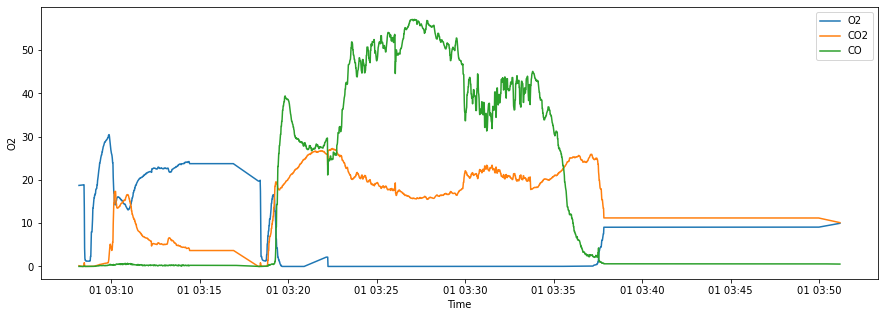

In [21]:
fig = plt.figure(figsize=(15,5));
sns.lineplot(x='Time', y='O2', data=gas_train[gas_train['NPLV']==510008], label='O2');
sns.lineplot(x='Time', y='CO2', data=gas_train[gas_train['NPLV']==510008], label='CO2');
sns.lineplot(x='Time', y='CO', data=gas_train[gas_train['NPLV']==510008], label='CO');

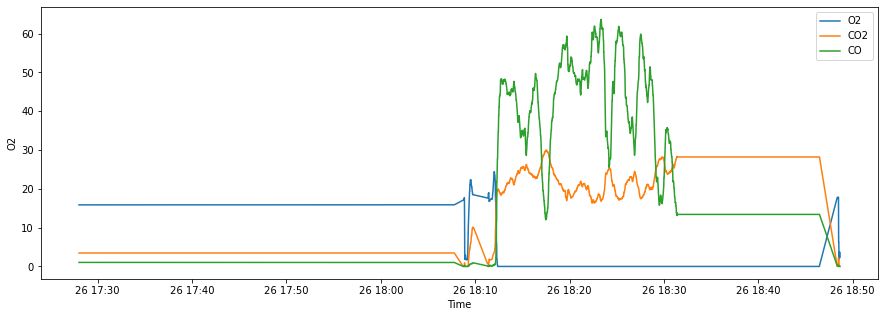

In [22]:
fig = plt.figure(figsize=(15,5));
sns.lineplot(x='Time', y='O2', data=gas_train[gas_train['NPLV']==512322], label='O2');
sns.lineplot(x='Time', y='CO2', data=gas_train[gas_train['NPLV']==512322], label='CO2');
sns.lineplot(x='Time', y='CO', data=gas_train[gas_train['NPLV']==512322], label='CO');

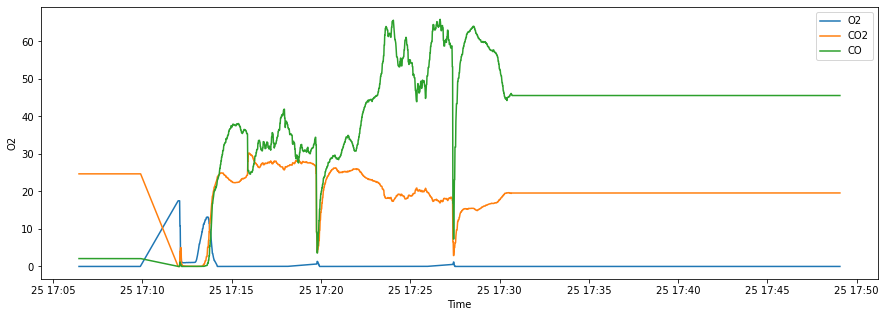

In [23]:
fig = plt.figure(figsize=(15,5));
sns.lineplot(x='Time', y='O2', data=gas_train[gas_train['NPLV']==512300], label='O2');
sns.lineplot(x='Time', y='CO2', data=gas_train[gas_train['NPLV']==512300], label='CO2');
sns.lineplot(x='Time', y='CO', data=gas_train[gas_train['NPLV']==512300], label='CO');

In [24]:
# Суммарный вес лома, идикатор присутсвия типа лома, вес конктретного типа лома
lom_train.head(2)

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700


In [25]:
plavki_train

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...
2132,512318,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281,коническая,22,5 сопловая,56
2133,512319,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282,коническая,23,5 сопловая,57
2134,512320,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283,коническая,24,5 сопловая,58
2135,512321,2021-04-26 16:22:37,2021-04-26 17:23:37,40Х.1,МНЛЗ,3284,коническая,25,5 сопловая,59


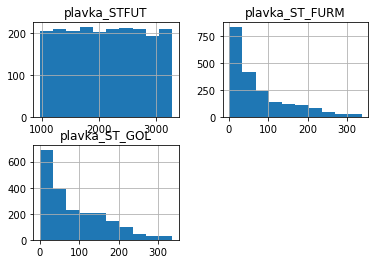

In [26]:
# Логарифм последних двух стойкостей?
plavki_train[['plavka_STFUT', 'plavka_ST_FURM', 'plavka_ST_GOL']].hist();

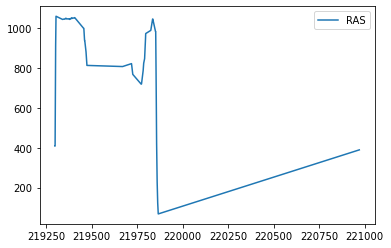

In [27]:
# Что за точка?
produv_train[produv_train['NPLV']==510142].sort_values('SEC')[['RAS']].plot();

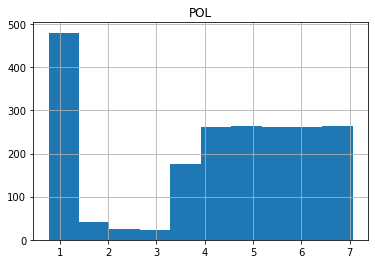

In [28]:
produv_train[produv_train['NPLV']==510008][['POL']].hist();

In [29]:
# Суммарный вес сыпучих, идикатор присутсвия типа сыпучих, вес конктретного типа сыпучих + время
sip_train

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
31579,512322,408,изв_ЦОИ,30,2021-04-26 18:28:06
31580,512322,408,изв_ЦОИ,490,2021-04-26 18:28:07
31581,512322,408,изв_ЦОИ,20,2021-04-26 18:28:22
31582,512322,408,изв_ЦОИ,970,2021-04-26 18:30:26


In [30]:
target_train.describe()

,NPLV,TST,C
count,2061.000000,2061.000000,2061.000000
mean,511161.988840,1649.159631,0.082379
std,665.243219,30.676012,0.100507
min,510008.000000,1406.000000,0.016000
25%,510584.000000,1630.000000,0.044000
50%,511163.000000,1652.000000,0.056000
75%,511729.000000,1670.000000,0.080000
max,512322.000000,1750.000000,1.050000


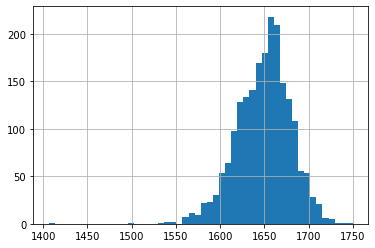

In [31]:
target_train['TST'].hist(bins=50);

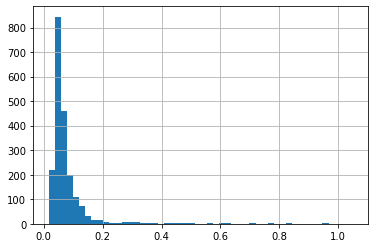

In [32]:
# Логарифм
target_train['C'].hist(bins=50);

# Feature Engineering

In [15]:
# Функция генерации фичей на ломах

def make_lom_features(lom_train, lom_test):
    """
    Parametrs:
        lom_train (pd.DataFrame): train по лому
        lom_test (pd.DataFrame): test по лому
    
    Returns:
        result_train (pd.DataFrame): агрегированные фичи по лому для трейна
        result_test (pd.DataFrame): агрегированные фичи по лому для теста
    """
    df_train = lom_train.copy()
    df_test = lom_test.copy()

    df = pd.concat([df_train, df_test])

    count_types = df.groupby('NPLV')['VDL'].count().to_frame().reset_index().rename(columns={'VDL': 'lom_types_count'})
    lom_sum = df.groupby('NPLV')['VES'].sum().to_frame().reset_index().rename(columns={'VES': 'total_lom_weight'})
    weight_of_each_lom_type = df.pivot('NPLV', 'VDL', 'VES').rename(
        columns={col: str(col) + '_weght' for col in df['VDL'].unique()}).fillna(0)
    appearence_of_each_lom_type = pd.pivot_table(df, values='VES', index=['NPLV'],
                                                 columns=['VDL'], aggfunc='count') \
        .rename(columns={col: str(col) + '_isin' for col in df['VDL'].unique()}).fillna(0)

    data_frames = [count_types, lom_sum, weight_of_each_lom_type, appearence_of_each_lom_type]

    df_merged = reduce(lambda left, right: pd.merge(left, right, on=['NPLV'], how='inner'), data_frames)

    result_train = df_merged[df_merged['NPLV'].isin(df_train['NPLV'].unique())]
    result_test = df_merged[df_merged['NPLV'].isin(df_test['NPLV'].unique())]

    return result_train, result_test

In [16]:
# Чугун оставляем как есть
def make_chugun_features(chugun_train, chugun_test):
    df_train = chugun_train.copy()
    df_test = chugun_test.copy()

    # Надо ли оно нам?
    mask = (df_train['T'] == 0)
    df_train.loc[mask, 'T'] = df_train['T'].median()
    mask = (df_test['T'] == 0)
    df_test.loc[mask, 'T'] = df_train['T'].median()

    return df_train, df_test

In [17]:
# Генерим фичи по сыпучим

def make_sip_features(sip_train, sip_test):
    """
    Parametrs:
        sip_train (pd.DataFrame): train по сыпучим
        sip_test (pd.DataFrame): test по сыпучим
    
    Returns:
        result_train (pd.DataFrame): агрегированные фичи по сыпучим для трейна
        result_test (pd.DataFrame): агрегированные фичи по сыпучим для теста
    """
    
    def sip_mapper(NMSYP):
        if NMSYP in ['изв_ЦОИ', 'ФЛЮМАГ', 'агл_офл_с', 'долом_сыр', 'изв_отсев', 'Флюс ФОМИ', 'Долом(сыр)',
                     'агл_офл_с']:
            return 'Флюс'
        else:
            return 'Топливо'

    df_train = sip_train.copy()
    df_test = sip_test.copy()

    df = pd.concat([df_train, df_test])

    df['GRSYP'] = df['NMSYP'].apply(sip_mapper)

    count_types = df.groupby(['NPLV'])['VDSYP'].count().to_frame().reset_index().rename(
        columns={'VDSYP': 'sip_types_count'})

    weight_of_each_sip_type_agg = df.pivot_table(index='NPLV', columns='GRSYP', values='VSSYP', aggfunc='sum') \
        .rename(columns={col: str(col) + '_weght_agg' for col in df['GRSYP'].unique()}).fillna(0)
    appearence_count_of_each_lom_type_agg = pd.pivot_table(df, values='VSSYP', index=['NPLV'],
                                                           columns=['GRSYP'], aggfunc='count').rename(
        columns={col: str(col) + '_count' for col in df['GRSYP'].unique()}).fillna(0)

    sip_sum = df.groupby(['NPLV'])['VSSYP'].sum().to_frame().reset_index().rename(columns={'VSSYP': 'total_sip_weight'})
    weight_of_each_sip_type = df.pivot_table(index='NPLV', columns='VDSYP', values='VSSYP', aggfunc='sum') \
        .rename(columns={col: str(col) + '_weght' for col in df['VDSYP'].unique()}).fillna(0)

    appearence_count_of_each_lom_type = pd.pivot_table(df, values='VSSYP', index=['NPLV'],
                                                       columns=['VDSYP'], aggfunc='count').rename(
        columns={col: str(col) + '_count' for col in df['VDSYP'].unique()}).fillna(0)

    data_frames = [count_types, sip_sum, weight_of_each_sip_type, appearence_count_of_each_lom_type,
                   weight_of_each_sip_type_agg, appearence_count_of_each_lom_type_agg]

    df_merged = reduce(lambda left, right: pd.merge(left, right, on=['NPLV'], how='inner'), data_frames)

    result_train = df_merged[df_merged['NPLV'].isin(df_train['NPLV'].unique())]
    result_test = df_merged[df_merged['NPLV'].isin(df_test['NPLV'].unique())]

    return result_train, result_test

In [18]:
# Генерим фичи по плавке

def make_plavki_features(plavki_train, plavki_test,
                         for_dummies=['plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL']):
    """
    Parametrs:
        plavki_train (pd.DataFrame): train по плавкам
        plavki_test (pd.DataFrame): test по плавкам
    
    Returns:
        result_train (pd.DataFrame): агрегированные фичи по плавкам для трейна
        result_test (pd.DataFrame): агрегированные фичи по плавкам для теста
    """
    
    df_train = plavki_train.copy()
    df_test = plavki_test.copy()

    df = pd.concat([df_train, df_test])
    df['plavka_DUR'] = (plavki_train['plavka_VR_KON'] - plavki_train['plavka_VR_NACH']) / np.timedelta64(1, 'm')

    df[['plavka_ST_FURM', 'plavka_ST_GOL']] = np.log(df[['plavka_ST_FURM', 'plavka_ST_GOL']])
    df_dummies = pd.get_dummies(df, columns=for_dummies, drop_first=True)

    result_train = df_dummies[df_dummies['NPLV'].isin(df_train['NPLV'].unique())]
    result_test = df_dummies[df_dummies['NPLV'].isin(df_test['NPLV'].unique())]

    return result_train, result_test

In [19]:
# Оставляем только время плавки

def make_chronom_features(chronom_train, chronom_test, pred_type=None):
    """
    Оставляет от хронометража только время плавки. Выкидывает плавки с додувкой заданного типа
    Parametrs:
        chronom_train (pd.DataFrame): train по хронометражу
        chronom_test (pd.DataFrame): test по хронометражу
        pred_type (pd.DataFrame): тип додувки, который будет выкидываться
    
    Returns:
        result_train (pd.DataFrame): агрегированные фичи по хронометражу для трейна
        result_test (pd.DataFrame): агрегированные фичи по хронометражу для теста
    """
    
    chronom_train = chronom_train[~(chronom_train['VR_NACH'].dt.year < 2021)]
    chronom_test = chronom_test[~(chronom_test['VR_NACH'].dt.year < 2021)]

    if pred_type == 'C':
        df = chronom_train.groupby('NPLV')['NOP'].apply(lambda x: ((x == 'Додувка на C') \
                                                                   | (x == 'Скач. шлака')).sum()).reset_index(
            name='count')
    elif pred_type == 'TST':
        df = chronom_train.groupby('NPLV')['NOP'].apply(lambda x: ((x == 'Додувка на t') \
                                                                   | (x == 'Скач. шлака')).sum()).reset_index(
            name='count')
    else:
        df = chronom_train.groupby('NPLV')['NOP'].apply(lambda x: ((x == 'Додувка на t') | (x == 'Додувка на C') \
                                                                   | (x == 'Скач. шлака')).sum()).reset_index(
            name='count')

    df = df[df['count'] == 0]

    chronom_train = chronom_train[chronom_train['NPLV'].isin(df['NPLV'])]

    chronom_train['produv_DUR'] = (chronom_train['VR_KON'] - chronom_train['VR_NACH']) / np.timedelta64(1, 'm')
    chronom_test['produv_DUR'] = (chronom_test['VR_KON'] - chronom_test['VR_NACH']) / np.timedelta64(1, 'm')

    result_train = chronom_train[chronom_train['NOP'] == 'Продувка'].drop(['TYPE_OPER', 'NOP', 'O2'], axis=1)
    result_test = chronom_test[chronom_test['NOP'] == 'Продувка'].drop(['TYPE_OPER', 'NOP', 'O2'], axis=1)

    return result_train, result_test

In [20]:
# Генерим фичи продувки

def make_produv_reg(df):
    result_df = pd.DataFrame(columns=['NPLV', 'RAS_slope'])

    for NPLV in df['NPLV'].unique():
        temp_df = df[df['NPLV'] == NPLV]
        try:
            temp_df = temp_df.iloc[60:, ].iloc[:-60, ]

            temp_df2 = pd.DataFrame({'NPLV': [NPLV],
                                     'RAS_slope': [linregress(temp_df['Time_after_NACH'], temp_df['RAS']).slope]})
        except:
            temp_df2 = pd.DataFrame({'NPLV': [NPLV],
                                     'RAS_slope': [np.nan]})

        result_df = result_df.append(temp_df2)

    result_df['RAS_slope'].fillna(result_df['RAS_slope'].median(), inplace=True)
    return result_df

def make_produv_features(produv_train, produv_test, chronom_fetures_train, chronom_fetures_test):
    """
    Оставляет от хронометража только время плавки. Выкидывает плавки с додувкой заданного типа
    Parametrs:
        produv_train (pd.DataFrame): train по продувке
        produv_test (pd.DataFrame): test по продувке
        chronom_fetures_train (pd.DataFrame): датафрейм с трейновыми периодами продувки
        chronom_fetures_test (pd.DataFrame): датафрейм с тестовыми периодами продувки
    
    Returns:
        result_train (pd.DataFrame): агрегированные фичи по продувке для трейна
        result_test (pd.DataFrame): агрегированные фичи по продувке для теста
    """
    
    produv_train = produv_train.merge(chronom_fetures_train, how='left', on='NPLV')
    produv_test = produv_test.merge(chronom_fetures_test, how='left', on='NPLV')

    produv_train = produv_train[
        (produv_train['SEC'] >= produv_train['VR_NACH']) & (produv_train['SEC'] <= produv_train['VR_KON'])]
    produv_test = produv_test[
        (produv_test['SEC'] >= produv_test['VR_NACH']) & (produv_test['SEC'] <= produv_test['VR_KON'])]

    produv_train['Time_after_NACH'] = (produv_train['SEC'] - produv_train['VR_NACH']) / np.timedelta64(1, 'm')
    produv_test['Time_after_NACH'] = (produv_test['SEC'] - produv_test['VR_NACH']) / np.timedelta64(1, 'm')

    result_train = produv_train.groupby('NPLV').agg({'RAS': ['sum', 'mean'],
                                                     'POL': 'mean'}).reset_index()
    result_test = produv_test.groupby('NPLV').agg({'RAS': ['sum', 'mean'],
                                                   'POL': 'mean'}).reset_index()

    result_train.columns = result_train.columns.droplevel()
    result_train.columns = ['NPLV', 'RAS_sum', 'RAS_mean', 'POL_mean']
    result_test.columns = result_test.columns.droplevel()
    result_test.columns = ['NPLV', 'RAS_sum', 'RAS_mean', 'POL_mean']

    result_train2 = make_produv_reg(produv_train)
    result_test2 = make_produv_reg(produv_test)

    result_train = result_train.merge(result_train2, how='inner', on='NPLV')
    result_test = result_test.merge(result_test2, how='inner', on='NPLV')

    return result_train, result_test

In [21]:
# Генерим фичи по газу

def make_agg_gas_features(df):
    result_df = pd.DataFrame(
        columns=['NPLV', 'O2_slope', 'final_balance', 'final_AR', 'final_T', 'from_cross_till_end'])
    for NPLV in df['NPLV'].unique():
        temp_df = df[df['NPLV'] == NPLV]

        temp_df['previous_30'] = temp_df['rolling_T30'].shift(1)
        temp_df['previous_300'] = temp_df['rolling_T300'].shift(1)

        temp_df['crossing'] = (temp_df['previous_300'] < temp_df['previous_30']) & (
                temp_df['rolling_T300'] >= temp_df['rolling_T30'])
        temp_df['crossing_till_VR_KON'] = temp_df['crossing'] * (temp_df['VR_KON'] - temp_df['Time']) / np.timedelta64(
            1, 'm')
        temp_df2 = pd.DataFrame({'NPLV': [NPLV],
                                 'O2_slope': [linregress(temp_df['Time_after_NACH'], temp_df['O2_pressure']).slope],
                                 'final_balance': [
                                     temp_df['rolling_balance30'].iloc[-1] - temp_df['rolling_balance300'].iloc[-1]],
                                 'final_AR': [temp_df['rolling_AR30'].iloc[-1] / temp_df['rolling_AR300'].iloc[-1]],
                                 'final_T': [temp_df['rolling_T30'].iloc[-1] / temp_df['rolling_T300'].iloc[-1]],
                                 'from_cross_till_end': [temp_df['crossing_till_VR_KON'].max()]})
        result_df = result_df.append(temp_df2)

    result_df2 = df.groupby('NPLV').agg({'V': ['sum', 'max'],
                                         'T': ['mean', 'max'],
                                         'O2': ['min', 'mean', 'max'],
                                         'N2': ['mean', 'max'],
                                         'H2': ['mean', 'max'],
                                         'CO2': ['mean', 'max'],
                                         'CO': ['mean', 'max'],
                                         'AR': ['mean', 'max'],
                                         'O2_pressure': ['min', 'mean', 'max']}).reset_index()
    result_df2.columns = result_df2.columns.droplevel()
    result_df2.columns = ['NPLV', 'V_sum', 'V_max', 'T_mean', 'T_max', 'O2_min', 'O2_mean', 'O2_max',
                          'N2_mean', 'N2_max', 'H2_mean', 'H2_max', 'CO2_mean', 'CO2_max',
                          'CO_mean', 'CO_max', 'AR_mean', 'AR_max', 'O2_pressure_min',
                          'O2_pressure_mean', 'O2_pressure_max']

    result_df.fillna(0, inplace=True)  # Na не было, но теоретически могут появится. Для стабильности модели

    result_df = result_df.merge(result_df2, how='inner', on='NPLV')
    return result_df

def make_gas_features(gas_train, gas_test, chronom_fetures_train, chronom_fetures_test):
    gas_train = gas_train.merge(chronom_fetures_train[['NPLV', 'VR_NACH', 'VR_KON']], how='left', on='NPLV')
    gas_train = gas_train[(gas_train['Time'] >= gas_train['VR_NACH']) & (gas_train['Time'] <= gas_train['VR_KON'])]
    gas_test = gas_test.merge(chronom_fetures_test[['NPLV', 'VR_NACH', 'VR_KON']], how='left', on='NPLV')
    gas_test = gas_test[(gas_test['Time'] >= gas_test['VR_NACH']) & (gas_test['Time'] <= gas_test['VR_KON'])]

    df_train = gas_train.copy()
    df_test = gas_test.copy()

    df_train['CO/CO2'] = df_train['CO'] / df_train['CO2']
    df_train['balance'] = df_train['CO'] + df_train['CO2'] - df_train['O2']
    df_train['T фурмы'] = df_train[['T фурмы 1', 'T фурмы 1']].max(axis=1)
    df_train['Time_after_NACH'] = (df_train['Time'] - df_train['VR_NACH']) / np.timedelta64(1, 'm')

    for feature in ['T', 'V', 'AR', 'balance', 'O2_pressure']:
        df_train['rolling_' + feature + '30'] = df_train.groupby('NPLV')[feature].transform(
            lambda x: x.rolling(30, 1).mean())
        df_train['rolling_' + feature + '300'] = df_train.groupby('NPLV')[feature].transform(
            lambda x: x.rolling(300, 1).mean())

    df_test['CO/CO2'] = df_test['CO'] / df_test['CO2']
    df_test['balance'] = df_test['CO'] + df_test['CO2'] - df_test['O2']
    df_test['T фурмы'] = df_test[['T фурмы 1', 'T фурмы 1']].max(axis=1)
    df_test['Time_after_NACH'] = (df_test['Time'] - df_test['VR_NACH']) / np.timedelta64(1, 'm')

    for feature in ['T', 'V', 'AR', 'balance', 'O2_pressure']:
        df_test['rolling_' + feature + '30'] = df_test.groupby('NPLV')[feature].transform(
            lambda x: x.rolling(30, 1).mean())
        df_test['rolling_' + feature + '300'] = df_test.groupby('NPLV')[feature].transform(
            lambda x: x.rolling(300, 1).mean())

    result_train = make_agg_gas_features(df_train)
    result_test = make_agg_gas_features(df_test)

    return result_train, result_test


In [23]:
# Логарифмируем таргет
def target_preparation(target_train):
    df = target_train.copy()

    df['C'] = np.log(df['C'])

    return df

In [42]:
# lom_features_train, lom_features_test = make_lom_features(lom_train, lom_test)

In [43]:
# chugun_fetures_train, chugun_fetures_test = make_chugun_features(chugun_train, chugun_test)

In [44]:
# gas_fetures_train, gas_fetures_test =make_gas_features(gas_train, gas_test)

In [45]:
# plavki_fetures_train, plavki_fetures_test = make_plavki_features(plavki_train, plavki_test,
#                                                                   for_dummies=['plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL'])

In [46]:
# sip_fetures_train, sip_fetures_test = make_sip_features(sip_train, sip_test)

In [47]:
# target = target_preparation(target_train)

In [24]:
# Сборка фичей в единый датафрейм

def assemble_features(drop_time_features=True, pred_type=None):
    lom_features_train, lom_features_test = make_lom_features(lom_train, lom_test)

    chugun_fetures_train, chugun_fetures_test = make_chugun_features(chugun_train, chugun_test)
    plavki_fetures_train, plavki_fetures_test = make_plavki_features(plavki_train, plavki_test,
                                                                     for_dummies=['plavka_NMZ', 'plavka_NAPR_ZAD',
                                                                                  'plavka_TIPE_FUR', 'plavka_TIPE_GOL'])
    sip_fetures_train, sip_fetures_test = make_sip_features(sip_train, sip_test)

    chronom_features_train, chronom_features_test = make_chronom_features(chronom_train, chronom_test, pred_type)
    produv_fetures_train, produv_fetures_test = make_produv_features(produv_train, produv_test,
                                                                     chronom_features_train, chronom_features_test)
    
    gas_features_train, gas_features_test = make_gas_features(gas_train, gas_test, chronom_features_train, chronom_features_test)
    
    target = target_preparation(target_train)

    df_list_train = [lom_features_train, chugun_fetures_train, plavki_fetures_train, sip_fetures_train,
                     chronom_features_train, produv_fetures_train, gas_features_train, target]
    
    df_list_test = [lom_features_test, chugun_fetures_test, plavki_fetures_test, sip_fetures_test,
                    chronom_features_test, produv_fetures_test, gas_features_test]

    train = reduce(lambda left, right: pd.merge(left, right, on=['NPLV'], how='inner'), df_list_train)
    test = reduce(lambda left, right: pd.merge(left, right, on=['NPLV'], how='inner'), df_list_test)

    train.drop('NPLV', axis=1, inplace=True)
    test.drop('NPLV', axis=1, inplace=True)
    
    train.columns = [col.strip() for col in train.columns]
    test.columns = [col.strip() for col in test.columns]
    
#     train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#     test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # assert len(train) == 1026
    assert len(test) == 780

    if drop_time_features:
        train.drop(['DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON', 'VR_NACH', 'VR_KON'], axis=1, inplace=True)
        test.drop(['DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON', 'VR_NACH', 'VR_KON'], axis=1, inplace=True)

    X_train, y_train = train.drop(['TST', 'C'], axis=1), train[['TST', 'C']]
    X_test = test

    return X_train, y_train, X_test

# Model fitting

In [25]:
# Метрика позволяющая рассчитывать скор для двух регрессий отдельно

def metric(true, preds, type_=None):
    """
    true[['C', 'TST']] - preds[['C', 'TST']]
    """
    if type_ == 'TST':
        delta_t = np.abs(np.array(true['TST']) - np.array(preds['TST']))
        hit_rate_t = np.int64(delta_t < 20)

        N = np.size(true['TST'])

        return np.sum(hit_rate_t) / N

    if type_ == 'C':
        delta_c = np.abs(np.array(true['C']) - np.array(np.log(preds['C'])))
        hit_rate_c = np.int64(delta_c < 0.02)

        N = np.size(true['C'])

        return np.sum(hit_rate_c) / N

    delta_c = np.abs(np.array(true['C']) - np.array(preds['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true['TST']) - np.array(preds['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(true['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [26]:
# Функция обучения модели

def fit_oof_model(X, y, X_, pred_type, model, n_itter, n_splits, sample_submission):
    kFold_random_state = list(range(10, 10 + n_itter))
    n_splits = n_splits
    weight = n_splits * n_itter

    final_loss = []

    # файл для записи финального результата
    submission = sample_submission.copy()
    submission[pred_type] = 0

    for ind_k, random_state in enumerate(kFold_random_state):
        kFold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        total_loss = []

        for iteration, (train_index, valid_index) in enumerate(kFold.split(X, y)):

            X_train, X_valid = X.iloc[train_index].reset_index(drop=True), X.iloc[valid_index].reset_index(drop=True)
            y_train, y_valid = y[train_index], y[valid_index]

            model.fit(X_train, y_train)

            if pred_type == 'C':
                valid_pred = pd.DataFrame(list(np.exp(model.predict(X_valid))), columns=[pred_type])
            else:
                valid_pred = pd.DataFrame(list(model.predict(X_valid)), columns=[pred_type])

            loss = metric(pd.DataFrame(y_valid, columns=[pred_type]), valid_pred, pred_type)

            if pred_type == 'C':
                predict = np.exp(model.predict(X_))
            else:
                predict = model.predict(X_)

            submission[pred_type] = submission[pred_type] + predict / weight

            total_loss.append(np.mean(loss))

        final_loss.append(np.mean(total_loss))
        print(f'Fold({ind_k}) metric: {np.mean(total_loss)}')
    print(f'############## {pred_type} ##############')
    print(f'Final metric: {np.mean(final_loss)}')

    return submission

In [27]:
# Функция подбора гиперпараметров

def optuna_tune(X, y, pred_type, n_trials=200):
    sampler = TPESampler(seed=SEED)

    def create_model(trial):
        n_estimators = trial.suggest_int("n_estimators", 30, 2000)
        max_depth = trial.suggest_int('max_depth', 3, 30)
        learning_rate = trial.suggest_uniform('learning_rate', 0.001, 0.2)
        feature_fraction = trial.suggest_uniform('feature_fraction', 0.01, 1.0)
        bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.01, 1.0)

        # Особые
#         boosting = trial.suggest_categorical('boosting', ['gbdt', 'dart'])
        objective = trial.suggest_categorical('objective', ['regression', 'regression_l1'])
        lambda_l1 = trial.suggest_uniform('lambda_l1', 0.01, 5.0)

        model = lgbm.LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            feature_fraction=feature_fraction,
            bagging_fraction=bagging_fraction,
            objective=objective,
#             boosting=boosting,
            lambda_l1=lambda_l1,
            random_state=SEED,
            n_jobs=-1)

        return model

    def objective(trial):
        np.random.seed(SEED)
        model = create_model(trial)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random.randint(1, 10000), test_size=0.2)
        model.fit(X_train, y_train)

        if pred_type == 'C':
            result = pd.DataFrame(list(np.exp(model.predict(X_test))), columns=[pred_type])
        else:
            result = pd.DataFrame(list(model.predict(X_test)), columns=[pred_type])

        score = metric(pd.DataFrame(y_test, columns=[pred_type]), result, pred_type)

        return score

    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials)
    params_lgbm = study.best_params

    return params_lgbm

In [28]:
# Запуск out of fold валидации

def fit_via_oof(model_C, model_T, 
                 model_params_C, model_params_T, 
                 X_train_C, y_train_C, X_test_C,
                 X_train_T, y_train_T, X_test_T,
                 sample_submission):
    
    sample = sample_submission.copy()
        
    model_C = model_C(**model_params_C)
    sample = fit_oof_model(X_train_C, y_train_C, X_test_C, 'C', model_C, 5, 10, sample)

    model_T = model_T(**model_params_T)
    sample = fit_oof_model(X_train_T, y_train_T, X_test_T, 'TST', model_T, 5, 10, sample)

    return sample

In [29]:
# Собираем датасет

X_train_C, y_train_C, X_test_C = assemble_features(drop_time_features=True, pred_type='C')
# model_params_C = optuna_tune(X_train_C, y_train_C['C'], 'C', n_trials=500)

X_train_T, y_train_T, X_test_T = assemble_features(drop_time_features=True, pred_type='TST')
model_params_T = optuna_tune(X_train_T, y_train_T['TST'], 'TST', n_trials=500)
model_params_C = {'n_estimators': 1852,
                'max_depth': 21,
                'learning_rate': 0.012635595344989889,
                'feature_fraction': 0.5581196569773588,
                'bagging_fraction': 0.9412971437064724,
                'boosting': 'gbdt',
                'objective': 'regression_l1',
                'lambda_l1': 1.4580826604655923,
                'random_state': 97}
                  
# model_params_T = {'n_estimators': 128,
#                  'max_depth': 10,
#                  'learning_rate': 0.060720726790417665,
#                  'feature_fraction': 0.887835491023886,
#                  'bagging_fraction': 0.01409366398139808,
#                  'boosting': 'gbdt',
#                  'objective': 'regression_l1',
#                  'lambda_l1': 1.646771281194907,
#                  'random_state': 97}

[I 2021-10-31 06:09:12,958] A new study created in memory with name: no-name-db95d1fc-8c87-44d6-9de8-36b8f8122c79
[I 2021-10-31 06:09:17,766] Trial 0 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1679, 'max_depth': 30, 'learning_rate': 0.08998360326704077, 'feature_fraction': 0.29173519893834526, 'bagging_fraction': 0.7735044221296565, 'objective': 'regression_l1', 'lambda_l1': 4.646468355737704}. Best is trial 0 with value: 0.6885245901639344.
[I 2021-10-31 06:09:18,977] Trial 1 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 433, 'max_depth': 12, 'learning_rate': 0.04326760992453423, 'feature_fraction': 0.3058715058487906, 'bagging_fraction': 0.3502139296872269, 'objective': 'regression', 'lambda_l1': 0.9821171584011686}. Best is trial 0 with value: 0.6885245901639344.
[I 2021-10-31 06:09:19,668] Trial 2 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 346, 'max_depth': 6, 'learning_rate': 0.08361511310387547

[I 2021-10-31 06:10:39,012] Trial 22 finished with value: 0.6491803278688525 and parameters: {'n_estimators': 1779, 'max_depth': 25, 'learning_rate': 0.09576159125688216, 'feature_fraction': 0.5514672333610312, 'bagging_fraction': 0.14779676491325983, 'objective': 'regression_l1', 'lambda_l1': 4.291124820555174}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:10:43,114] Trial 23 finished with value: 0.6852459016393443 and parameters: {'n_estimators': 1494, 'max_depth': 21, 'learning_rate': 0.10506711860569298, 'feature_fraction': 0.4089591435614508, 'bagging_fraction': 0.2181491165560567, 'objective': 'regression_l1', 'lambda_l1': 3.720931502210852}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:10:46,707] Trial 24 finished with value: 0.6557377049180327 and parameters: {'n_estimators': 1180, 'max_depth': 28, 'learning_rate': 0.0753166216518312, 'feature_fraction': 0.3859858612018604, 'bagging_fraction': 0.09347204580394489, 'objective': 'regression

[I 2021-10-31 06:12:33,657] Trial 44 finished with value: 0.6655737704918033 and parameters: {'n_estimators': 1327, 'max_depth': 5, 'learning_rate': 0.042586519319097335, 'feature_fraction': 0.9211727383601772, 'bagging_fraction': 0.15233119645266532, 'objective': 'regression', 'lambda_l1': 4.735352433652143}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:12:37,293] Trial 45 finished with value: 0.6819672131147541 and parameters: {'n_estimators': 1153, 'max_depth': 7, 'learning_rate': 0.018737819903186306, 'feature_fraction': 0.9562306542503274, 'bagging_fraction': 0.08579195307385024, 'objective': 'regression', 'lambda_l1': 4.417311460017769}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:12:38,733] Trial 46 finished with value: 0.7081967213114754 and parameters: {'n_estimators': 1385, 'max_depth': 3, 'learning_rate': 0.04526593362571321, 'feature_fraction': 0.8974739106776908, 'bagging_fraction': 0.0689725275794181, 'objective': 'regression', 'la

[I 2021-10-31 06:13:36,880] Trial 66 finished with value: 0.7377049180327869 and parameters: {'n_estimators': 1057, 'max_depth': 8, 'learning_rate': 0.08887138777985558, 'feature_fraction': 0.7930131392131967, 'bagging_fraction': 0.5651672821624738, 'objective': 'regression', 'lambda_l1': 4.860028413892632}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:13:38,731] Trial 67 finished with value: 0.6950819672131148 and parameters: {'n_estimators': 1071, 'max_depth': 10, 'learning_rate': 0.08685254422713277, 'feature_fraction': 0.7583684863410785, 'bagging_fraction': 0.5939676070973017, 'objective': 'regression', 'lambda_l1': 4.844915808510507}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:13:40,647] Trial 68 finished with value: 0.6983606557377049 and parameters: {'n_estimators': 876, 'max_depth': 8, 'learning_rate': 0.07620985324199814, 'feature_fraction': 0.7012398145402704, 'bagging_fraction': 0.538013693504498, 'objective': 'regression', 'lambda_

[I 2021-10-31 06:14:59,848] Trial 88 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 1073, 'max_depth': 29, 'learning_rate': 0.08318737139245927, 'feature_fraction': 0.6176895050880846, 'bagging_fraction': 0.1968195000506655, 'objective': 'regression_l1', 'lambda_l1': 2.5672833398551647}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:15:03,249] Trial 89 finished with value: 0.6983606557377049 and parameters: {'n_estimators': 809, 'max_depth': 27, 'learning_rate': 0.08605791941066777, 'feature_fraction': 0.6760023257603414, 'bagging_fraction': 0.029693604004004358, 'objective': 'regression_l1', 'lambda_l1': 4.518850533096537}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:15:09,701] Trial 90 finished with value: 0.6655737704918033 and parameters: {'n_estimators': 1362, 'max_depth': 29, 'learning_rate': 0.1105385000342514, 'feature_fraction': 0.6960533984042494, 'bagging_fraction': 0.5385383213854801, 'objective': 'regression

[I 2021-10-31 06:16:38,504] Trial 110 finished with value: 0.6786885245901639 and parameters: {'n_estimators': 451, 'max_depth': 4, 'learning_rate': 0.06153423802046944, 'feature_fraction': 0.2858210469109286, 'bagging_fraction': 0.0712624102159676, 'objective': 'regression', 'lambda_l1': 3.4058504721474905}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:16:51,177] Trial 111 finished with value: 0.6459016393442623 and parameters: {'n_estimators': 1792, 'max_depth': 14, 'learning_rate': 0.022274735657914844, 'feature_fraction': 0.9801510781162607, 'bagging_fraction': 0.03277968820149768, 'objective': 'regression_l1', 'lambda_l1': 2.76477209077556}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:17:01,193] Trial 112 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1617, 'max_depth': 14, 'learning_rate': 0.029747296734965113, 'feature_fraction': 0.9355250714459094, 'bagging_fraction': 0.12091344946360867, 'objective': 'regressio

[I 2021-10-31 06:18:22,932] Trial 132 finished with value: 0.6819672131147541 and parameters: {'n_estimators': 1406, 'max_depth': 3, 'learning_rate': 0.054715869307119774, 'feature_fraction': 0.38014893075546413, 'bagging_fraction': 0.17024132392727373, 'objective': 'regression', 'lambda_l1': 3.6875103995152463}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:18:28,054] Trial 133 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 1204, 'max_depth': 17, 'learning_rate': 0.06168879369472925, 'feature_fraction': 0.7682484961258813, 'bagging_fraction': 0.0443833583727535, 'objective': 'regression_l1', 'lambda_l1': 4.751248301136235}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:18:29,904] Trial 134 finished with value: 0.6721311475409836 and parameters: {'n_estimators': 1733, 'max_depth': 15, 'learning_rate': 0.07122330732542671, 'feature_fraction': 0.26137418368716747, 'bagging_fraction': 0.45630953087174075, 'objective': 'regres

[I 2021-10-31 06:19:51,875] Trial 154 finished with value: 0.6852459016393443 and parameters: {'n_estimators': 1433, 'max_depth': 29, 'learning_rate': 0.03127732980167794, 'feature_fraction': 0.8509275839785557, 'bagging_fraction': 0.13949256033827817, 'objective': 'regression', 'lambda_l1': 2.4635894206278715}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:19:53,697] Trial 155 finished with value: 0.6983606557377049 and parameters: {'n_estimators': 1492, 'max_depth': 5, 'learning_rate': 0.05223497901293515, 'feature_fraction': 0.19452589110276047, 'bagging_fraction': 0.2101261200441491, 'objective': 'regression', 'lambda_l1': 3.1927066468154144}. Best is trial 6 with value: 0.7377049180327869.
[I 2021-10-31 06:19:56,955] Trial 156 finished with value: 0.6983606557377049 and parameters: {'n_estimators': 1273, 'max_depth': 7, 'learning_rate': 0.027633963973144382, 'feature_fraction': 0.5827111645034145, 'bagging_fraction': 0.180343925418555, 'objective': 'regression_l

[I 2021-10-31 06:20:59,709] Trial 176 finished with value: 0.6557377049180327 and parameters: {'n_estimators': 1381, 'max_depth': 6, 'learning_rate': 0.06329198113710319, 'feature_fraction': 0.4387463109313644, 'bagging_fraction': 0.045745053965988006, 'objective': 'regression', 'lambda_l1': 4.841374363894699}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:21:05,043] Trial 177 finished with value: 0.6819672131147541 and parameters: {'n_estimators': 1344, 'max_depth': 8, 'learning_rate': 0.08400610080245842, 'feature_fraction': 0.8177486582980291, 'bagging_fraction': 0.3279159297247178, 'objective': 'regression_l1', 'lambda_l1': 3.13435092921922}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:21:06,414] Trial 178 finished with value: 0.6622950819672131 and parameters: {'n_estimators': 1472, 'max_depth': 5, 'learning_rate': 0.1949674709821678, 'feature_fraction': 0.9790871015477837, 'bagging_fraction': 0.0110493839185071, 'objective': 'regression',

[I 2021-10-31 06:22:21,017] Trial 198 finished with value: 0.6918032786885245 and parameters: {'n_estimators': 1018, 'max_depth': 27, 'learning_rate': 0.052764751123943396, 'feature_fraction': 0.8183333523006634, 'bagging_fraction': 0.6959456535278933, 'objective': 'regression_l1', 'lambda_l1': 4.762318955466287}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:22:25,129] Trial 199 finished with value: 0.7245901639344262 and parameters: {'n_estimators': 886, 'max_depth': 27, 'learning_rate': 0.059569096635592955, 'feature_fraction': 0.7819401424283966, 'bagging_fraction': 0.7720174843264968, 'objective': 'regression_l1', 'lambda_l1': 3.242273931295007}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:22:29,014] Trial 200 finished with value: 0.6786885245901639 and parameters: {'n_estimators': 795, 'max_depth': 27, 'learning_rate': 0.060123433855889724, 'feature_fraction': 0.7791939045105901, 'bagging_fraction': 0.7887976191425229, 'objective': 'regre

[I 2021-10-31 06:23:44,820] Trial 220 finished with value: 0.6721311475409836 and parameters: {'n_estimators': 1135, 'max_depth': 21, 'learning_rate': 0.05394031752250388, 'feature_fraction': 0.8213083544844965, 'bagging_fraction': 0.019174120954844817, 'objective': 'regression', 'lambda_l1': 4.833326359872465}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:23:49,175] Trial 221 finished with value: 0.6918032786885245 and parameters: {'n_estimators': 1089, 'max_depth': 22, 'learning_rate': 0.04902234604306003, 'feature_fraction': 0.8538862536669642, 'bagging_fraction': 0.034312933450953875, 'objective': 'regression', 'lambda_l1': 4.5381527309311736}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:23:51,382] Trial 222 finished with value: 0.6622950819672131 and parameters: {'n_estimators': 1168, 'max_depth': 29, 'learning_rate': 0.09706488877064004, 'feature_fraction': 0.4774203798740072, 'bagging_fraction': 0.0457256299663644, 'objective': 'regress

[I 2021-10-31 06:25:05,483] Trial 242 finished with value: 0.7278688524590164 and parameters: {'n_estimators': 1206, 'max_depth': 9, 'learning_rate': 0.04192983312127414, 'feature_fraction': 0.9118246696971342, 'bagging_fraction': 0.09631140513046285, 'objective': 'regression', 'lambda_l1': 4.664028172227254}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:25:09,165] Trial 243 finished with value: 0.6459016393442623 and parameters: {'n_estimators': 1188, 'max_depth': 10, 'learning_rate': 0.04294719386367958, 'feature_fraction': 0.9173054858238351, 'bagging_fraction': 0.09545615023301467, 'objective': 'regression', 'lambda_l1': 4.595153566027677}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:25:12,415] Trial 244 finished with value: 0.6655737704918033 and parameters: {'n_estimators': 893, 'max_depth': 10, 'learning_rate': 0.049813294995542, 'feature_fraction': 0.8710609493367948, 'bagging_fraction': 0.10523496364398614, 'objective': 'regression', 

[I 2021-10-31 06:26:39,133] Trial 264 finished with value: 0.6852459016393443 and parameters: {'n_estimators': 986, 'max_depth': 9, 'learning_rate': 0.07489778809403749, 'feature_fraction': 0.4428188401703425, 'bagging_fraction': 0.6468229907465126, 'objective': 'regression_l1', 'lambda_l1': 4.779137844819816}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:26:44,226] Trial 265 finished with value: 0.6852459016393443 and parameters: {'n_estimators': 1165, 'max_depth': 11, 'learning_rate': 0.06371890536116832, 'feature_fraction': 0.9525792615409387, 'bagging_fraction': 0.07439329396147143, 'objective': 'regression_l1', 'lambda_l1': 4.994338278194544}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:26:49,373] Trial 266 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 1061, 'max_depth': 8, 'learning_rate': 0.04891655315701217, 'feature_fraction': 0.9271904950945384, 'bagging_fraction': 0.7890230134080705, 'objective': 'regressi

[I 2021-10-31 06:28:11,810] Trial 286 finished with value: 0.6819672131147541 and parameters: {'n_estimators': 1147, 'max_depth': 22, 'learning_rate': 0.031007383894340827, 'feature_fraction': 0.6997208987292182, 'bagging_fraction': 0.03615114469552923, 'objective': 'regression', 'lambda_l1': 4.883837567653981}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:28:15,182] Trial 287 finished with value: 0.6754098360655738 and parameters: {'n_estimators': 1016, 'max_depth': 20, 'learning_rate': 0.027324699826725377, 'feature_fraction': 0.6675189132316008, 'bagging_fraction': 0.05838260812242499, 'objective': 'regression_l1', 'lambda_l1': 4.77559290638372}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:28:17,509] Trial 288 finished with value: 0.6262295081967213 and parameters: {'n_estimators': 741, 'max_depth': 7, 'learning_rate': 0.01706734098163448, 'feature_fraction': 0.7117495511325012, 'bagging_fraction': 0.5740379955115654, 'objective': 'regressi

[I 2021-10-31 06:29:47,268] Trial 308 finished with value: 0.7114754098360656 and parameters: {'n_estimators': 1516, 'max_depth': 8, 'learning_rate': 0.0028787558098499477, 'feature_fraction': 0.44892074996192183, 'bagging_fraction': 0.16722306634515482, 'objective': 'regression', 'lambda_l1': 4.81914905019642}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:29:50,661] Trial 309 finished with value: 0.639344262295082 and parameters: {'n_estimators': 1084, 'max_depth': 21, 'learning_rate': 0.008625799814740286, 'feature_fraction': 0.46944603710985305, 'bagging_fraction': 0.1870943046323869, 'objective': 'regression_l1', 'lambda_l1': 4.906675346111096}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:29:55,242] Trial 310 finished with value: 0.6524590163934426 and parameters: {'n_estimators': 1224, 'max_depth': 23, 'learning_rate': 0.010418351721077981, 'feature_fraction': 0.4579682635809335, 'bagging_fraction': 0.9837865209246965, 'objective': 'regre

[I 2021-10-31 06:31:10,290] Trial 330 finished with value: 0.6918032786885245 and parameters: {'n_estimators': 1138, 'max_depth': 20, 'learning_rate': 0.026723019456022193, 'feature_fraction': 0.5500059755381929, 'bagging_fraction': 0.8162565664850518, 'objective': 'regression', 'lambda_l1': 4.527755668074756}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:31:14,497] Trial 331 finished with value: 0.7016393442622951 and parameters: {'n_estimators': 1070, 'max_depth': 10, 'learning_rate': 0.042637171494201875, 'feature_fraction': 0.7607640582754867, 'bagging_fraction': 0.6897375293733774, 'objective': 'regression_l1', 'lambda_l1': 4.847245059646238}. Best is trial 172 with value: 0.740983606557377.
[I 2021-10-31 06:31:20,246] Trial 332 finished with value: 0.6754098360655738 and parameters: {'n_estimators': 1563, 'max_depth': 15, 'learning_rate': 0.022855721216374324, 'feature_fraction': 0.484934884783587, 'bagging_fraction': 0.13590665784571626, 'objective': 'regres

[I 2021-10-31 06:32:45,338] Trial 352 finished with value: 0.6786885245901639 and parameters: {'n_estimators': 1069, 'max_depth': 10, 'learning_rate': 0.020522557660140255, 'feature_fraction': 0.6366965859357003, 'bagging_fraction': 0.04325860980169399, 'objective': 'regression_l1', 'lambda_l1': 4.836777237599528}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:32:51,022] Trial 353 finished with value: 0.7147540983606557 and parameters: {'n_estimators': 1098, 'max_depth': 22, 'learning_rate': 0.026610119898012822, 'feature_fraction': 0.7423588091723862, 'bagging_fraction': 0.07085407750358247, 'objective': 'regression', 'lambda_l1': 4.623672697647944}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:32:59,641] Trial 354 finished with value: 0.6721311475409836 and parameters: {'n_estimators': 1750, 'max_depth': 19, 'learning_rate': 0.010896993971265864, 'feature_fraction': 0.7609093382486537, 'bagging_fraction': 0.08550962645102772, 'objective': 'r

[I 2021-10-31 06:34:01,768] Trial 374 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1465, 'max_depth': 9, 'learning_rate': 0.03484128870363903, 'feature_fraction': 0.6249553549751901, 'bagging_fraction': 0.0753983024590725, 'objective': 'regression', 'lambda_l1': 4.758919266810338}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:34:05,513] Trial 375 finished with value: 0.6950819672131148 and parameters: {'n_estimators': 1158, 'max_depth': 8, 'learning_rate': 0.04377051911401088, 'feature_fraction': 0.5084594530545498, 'bagging_fraction': 0.09806123691710317, 'objective': 'regression', 'lambda_l1': 3.8127912361095557}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:34:06,589] Trial 376 finished with value: 0.6459016393442623 and parameters: {'n_estimators': 214, 'max_depth': 15, 'learning_rate': 0.06012796016517611, 'feature_fraction': 0.8359034403216116, 'bagging_fraction': 0.13414505933378373, 'objective': 'regression

[I 2021-10-31 06:35:30,913] Trial 396 finished with value: 0.6754098360655738 and parameters: {'n_estimators': 1089, 'max_depth': 7, 'learning_rate': 0.0036275610304784814, 'feature_fraction': 0.44096999720942154, 'bagging_fraction': 0.10349303639779416, 'objective': 'regression', 'lambda_l1': 2.7705127667832223}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:35:33,282] Trial 397 finished with value: 0.6622950819672131 and parameters: {'n_estimators': 1226, 'max_depth': 17, 'learning_rate': 0.09432821756103524, 'feature_fraction': 0.5129671980490089, 'bagging_fraction': 0.17197693038376902, 'objective': 'regression', 'lambda_l1': 3.436033044621178}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:35:39,731] Trial 398 finished with value: 0.6327868852459017 and parameters: {'n_estimators': 1154, 'max_depth': 28, 'learning_rate': 0.1146367932503221, 'feature_fraction': 0.9116406669820898, 'bagging_fraction': 0.06182725103083558, 'objective': 'regre

[I 2021-10-31 06:37:00,312] Trial 418 finished with value: 0.7180327868852459 and parameters: {'n_estimators': 1145, 'max_depth': 25, 'learning_rate': 0.10853050526409698, 'feature_fraction': 0.4092521163521422, 'bagging_fraction': 0.11355910290096974, 'objective': 'regression_l1', 'lambda_l1': 4.897344957255197}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:37:06,773] Trial 419 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1402, 'max_depth': 9, 'learning_rate': 0.021716667953575464, 'feature_fraction': 0.9557243685106671, 'bagging_fraction': 0.011188158743090978, 'objective': 'regression', 'lambda_l1': 4.771407392326879}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:37:10,135] Trial 420 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1190, 'max_depth': 7, 'learning_rate': 0.042035135600395665, 'feature_fraction': 0.46417232924588053, 'bagging_fraction': 0.045565083151821145, 'objective': 'r

[I 2021-10-31 06:38:30,740] Trial 440 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1568, 'max_depth': 30, 'learning_rate': 0.0669318660702699, 'feature_fraction': 0.7794969191450032, 'bagging_fraction': 0.13047483439398394, 'objective': 'regression', 'lambda_l1': 4.808329183248351}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:38:37,120] Trial 441 finished with value: 0.6950819672131148 and parameters: {'n_estimators': 1103, 'max_depth': 25, 'learning_rate': 0.018008848442747333, 'feature_fraction': 0.7919930777011516, 'bagging_fraction': 0.015174493658243297, 'objective': 'regression', 'lambda_l1': 4.616717970906431}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:38:39,155] Trial 442 finished with value: 0.6885245901639344 and parameters: {'n_estimators': 1454, 'max_depth': 25, 'learning_rate': 0.09108878947917354, 'feature_fraction': 0.7192347177440964, 'bagging_fraction': 0.050244672590343056, 'objective': 'regre

[I 2021-10-31 06:40:05,012] Trial 462 finished with value: 0.6786885245901639 and parameters: {'n_estimators': 1016, 'max_depth': 29, 'learning_rate': 0.03544233336929506, 'feature_fraction': 0.9075703686610652, 'bagging_fraction': 0.03713833878419133, 'objective': 'regression', 'lambda_l1': 3.612781496502812}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:40:08,778] Trial 463 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 1219, 'max_depth': 7, 'learning_rate': 0.021802801951659023, 'feature_fraction': 0.6596513778371389, 'bagging_fraction': 0.11297895969368144, 'objective': 'regression', 'lambda_l1': 4.898962767383738}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:40:15,524] Trial 464 finished with value: 0.7213114754098361 and parameters: {'n_estimators': 1192, 'max_depth': 22, 'learning_rate': 0.012725313713102666, 'feature_fraction': 0.9680940066674065, 'bagging_fraction': 0.17765733473726297, 'objective': 'regres

[I 2021-10-31 06:41:27,006] Trial 484 finished with value: 0.7213114754098361 and parameters: {'n_estimators': 1038, 'max_depth': 14, 'learning_rate': 0.0768225636228674, 'feature_fraction': 0.9069298231133829, 'bagging_fraction': 0.0835871119211512, 'objective': 'regression', 'lambda_l1': 4.42541793007075}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:41:31,695] Trial 485 finished with value: 0.6688524590163935 and parameters: {'n_estimators': 1492, 'max_depth': 23, 'learning_rate': 0.005478507209165184, 'feature_fraction': 0.5650488825867018, 'bagging_fraction': 0.01448369706564926, 'objective': 'regression_l1', 'lambda_l1': 4.551194991784448}. Best is trial 340 with value: 0.7475409836065574.
[I 2021-10-31 06:41:37,091] Trial 486 finished with value: 0.7016393442622951 and parameters: {'n_estimators': 1099, 'max_depth': 29, 'learning_rate': 0.02546865927306438, 'feature_fraction': 0.8261353193617904, 'bagging_fraction': 0.032428840437762785, 'objective': 'regre

In [30]:
# Фиксируем seed

model_params_C['random_state'] = SEED
model_params_T['random_state'] = SEED

In [31]:
# Собираем сабмит

submit = fit_via_oof(lgbm.LGBMRegressor, lgbm.LGBMRegressor, 
                     model_params_C, model_params_T, 
                     X_train_C, y_train_C['C'], X_test_C,
                     X_train_T, y_train_T['TST'], X_test_T,
                     sample_submission)

Fold(0) metric: 0.08083354553942788
Fold(1) metric: 0.08281130634071811
Fold(2) metric: 0.07951786775316187
Fold(3) metric: 0.0847720906544436
Fold(4) metric: 0.07824463118580766
############## C ##############
Final metric: 0.08123588829471183
Fold(0) metric: 0.6909485724114207
Fold(1) metric: 0.6915247678018576
Fold(2) metric: 0.7008083935328517
Fold(3) metric: 0.688295493636051
Fold(4) metric: 0.6948701410388716
############## TST ##############
Final metric: 0.6932894736842106


In [32]:
# Пишем в csv
submit.to_csv('try_final_1.csv', index=False)

In [ ]:
# model_params_C
# {'bagging_fraction': 0.18405988487216057,
#  'feature_fraction': 0.8901858260316837,
#  'learning_rate': 0.07258833250377199,
#  'max_depth': 24,
#  'n_estimators': 400,
#  'random_state': 97}
# model_params_T
# {'bagging_fraction': 0.720359166194075,
#  'feature_fraction': 0.7551505116166282,
#  'learning_rate': 0.016051201776173113,
#  'max_depth': 12,
#  'n_estimators': 1103,
#  'random_state': 97}

In [ ]:
# 2 - 5
# Fold(0) deviation_metric: 0.05533980582524271
# Fold(1) deviation_metric: 0.05048543689320388
# Fold(2) deviation_metric: 0.04708737864077669
# Fold(3) deviation_metric: 0.050970873786407765
# Fold(4) deviation_metric: 0.051941747572815535
# ############## C ##############
# Final metric: 0.05116504854368932
# Fold(0) deviation_metric: 0.55
# Fold(1) deviation_metric: 0.5436893203883495
# Fold(2) deviation_metric: 0.55
# Fold(3) deviation_metric: 0.558252427184466
# Fold(4) deviation_metric: 0.5364077669902911
# ############## TST ##############
# Final metric: 0.5476699029126214 стало хуже

In [ ]:
# Fold(1) deviation_metric: 0.04999999999999999
# Fold(2) deviation_metric: 0.04757281553398058
# Fold(3) deviation_metric: 0.04514563106796117
# Fold(4) deviation_metric: 0.048058252427184464
# ############## C ##############
# Final metric: 0.04815533980582524
# Fold(0) deviation_metric: 0.5592233009708737
# Fold(1) deviation_metric: 0.5563106796116504
# Fold(2) deviation_metric: 0.5563106796116505
# Fold(3) deviation_metric: 0.558252427184466
# Fold(4) deviation_metric: 0.5495145631067961
# ############## TST ##############
# Final metric: 0.5559223300970874 убрал фичу id плавки и стало лучше

In [ ]:
# Fold(0) metric: 0.04757281553398058
# Fold(1) metric: 0.04077669902912621
# Fold(2) metric: 0.04466019417475727
# Fold(3) metric: 0.044174757281553394
# Fold(4) metric: 0.051941747572815535
# ############## C ##############
# Final metric: 0.045825242718446596
# Fold(0) metric: 0.5592233009708737
# Fold(1) metric: 0.5631067961165048
# Fold(2) metric: 0.5635922330097087
# Fold(3) metric: 0.553883495145631
# Fold(4) metric: 0.5587378640776699
# ############## TST ##############
# Final metric: 0.5597087378640776 оптуна на 500 трайлов + серегины фичи в спучих

In [ ]:
# Fold(0) metric: 0.06521093285799168
# Fold(1) metric: 0.057346574993633825
# Fold(2) metric: 0.0508360920125626
# Fold(3) metric: 0.06257533316356846
# Fold(4) metric: 0.06260504201680672
# ############## C ##############
# Final metric: 0.059714795008912656
# Fold(0) metric: 0.6437134502923977
# Fold(1) metric: 0.6370743034055727
# Fold(2) metric: 0.6424492604059167
# Fold(3) metric: 0.6306071551427589
# Fold(4) metric: 0.6240024079807361
# ############## TST ##############
# Final metric: 0.6355693154454765 вроде это когда первый раз развели потоки

In [ ]:
# Fold(0) metric: 0.05802139037433155
# Fold(1) metric: 0.06975638740344622
# Fold(2) metric: 0.06841100076394194
# Fold(3) metric: 0.06257108904167727
# Fold(4) metric: 0.05735930735930735
# ############## C ##############
# Final metric: 0.06322383498854087
# Fold(0) metric: 0.6332000343997248
# Fold(1) metric: 0.6272359821121432
# Fold(2) metric: 0.6391167870657035
# Fold(3) metric: 0.6450335397316821
# Fold(4) metric: 0.635844513243894
# ############## TST ##############
# Final metric: 0.6360861713106296 развели потоки + новые параметры в оптуне

In [ ]:
# Fold(0) metric: 0.08146591970121383
# Fold(1) metric: 0.0840887870299635
# Fold(2) metric: 0.07495119259825142
# Fold(3) metric: 0.08282403870639164
# Fold(4) metric: 0.08674136321195144
# ############## C ##############
# Final metric: 0.08201426024955435
# Fold(0) metric: 0.6738820089439284
# Fold(1) metric: 0.6777777777777778
# Fold(2) metric: 0.6739164086687307
# Fold(3) metric: 0.6797213622291022
# Fold(4) metric: 0.6798030615755074
# ############## TST ##############
# Final metric: 0.6770201238390092 добавили фичи по газу и на старых параметрах от оптуны

# Importance and shift

In [83]:
model_params_C_ = model_params_C
model_params_C_['importance_type'] = 'gain' 
model_params_T_ = model_params_T
model_params_T_['importance_type'] = 'gain' 

In [84]:
model_c = lgbm.LGBMRegressor(**model_params_C_)
model_t = lgbm.LGBMRegressor(**model_params_T_)

In [85]:
model_c.fit(X_train_C, y_train_C['C'])
model_t.fit(X_train_T, y_train_T['TST'])

LGBMRegressor(bagging_fraction=0.01409366398139808, boosting='gbdt',
              feature_fraction=0.887835491023886, importance_type='gain',
              lambda_l1=1.646771281194907, learning_rate=0.060720726790417665,
              max_depth=10, n_estimators=128, objective='regression_l1',
              random_state=97)

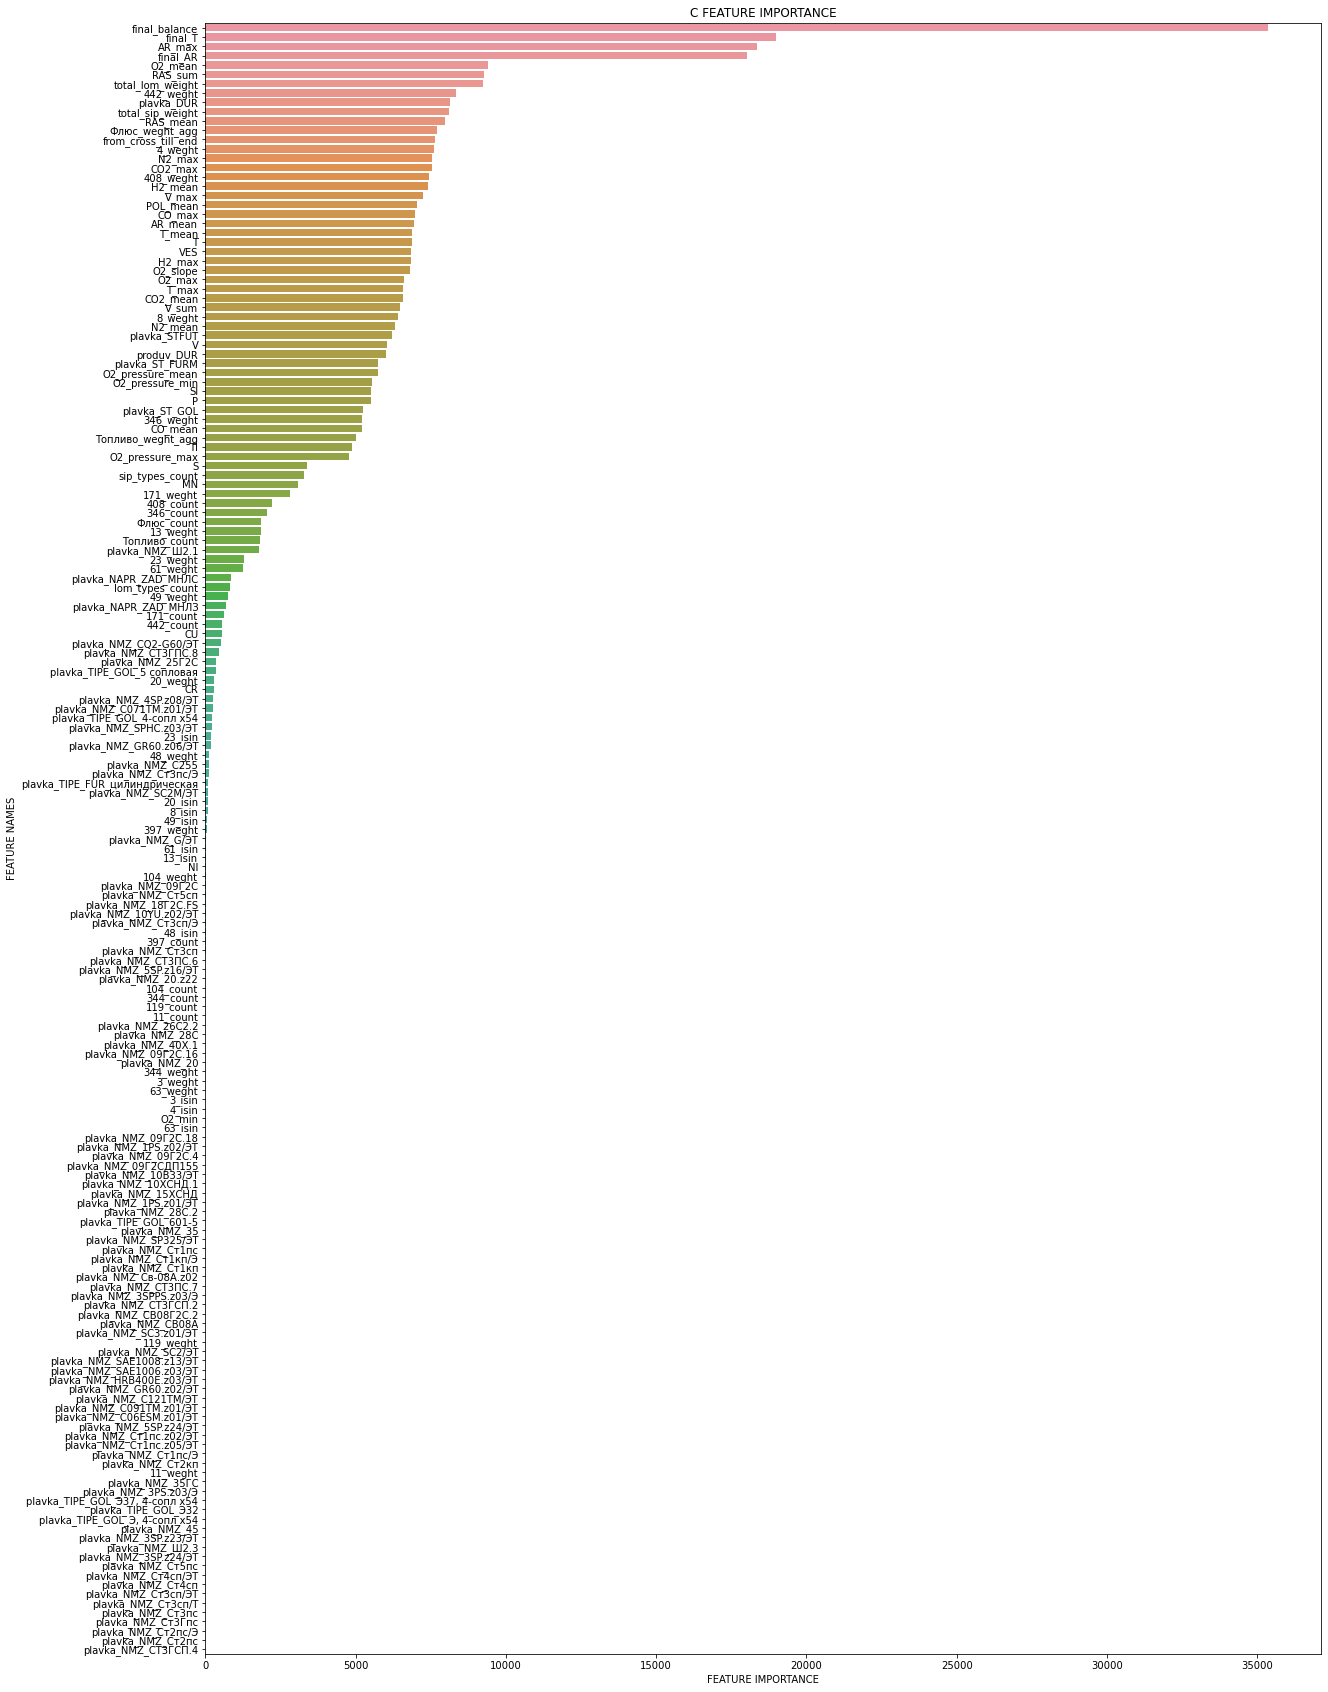

In [86]:
C =  plot_feature_importance(model_c.feature_importances_, X_train_C.columns, 'C')

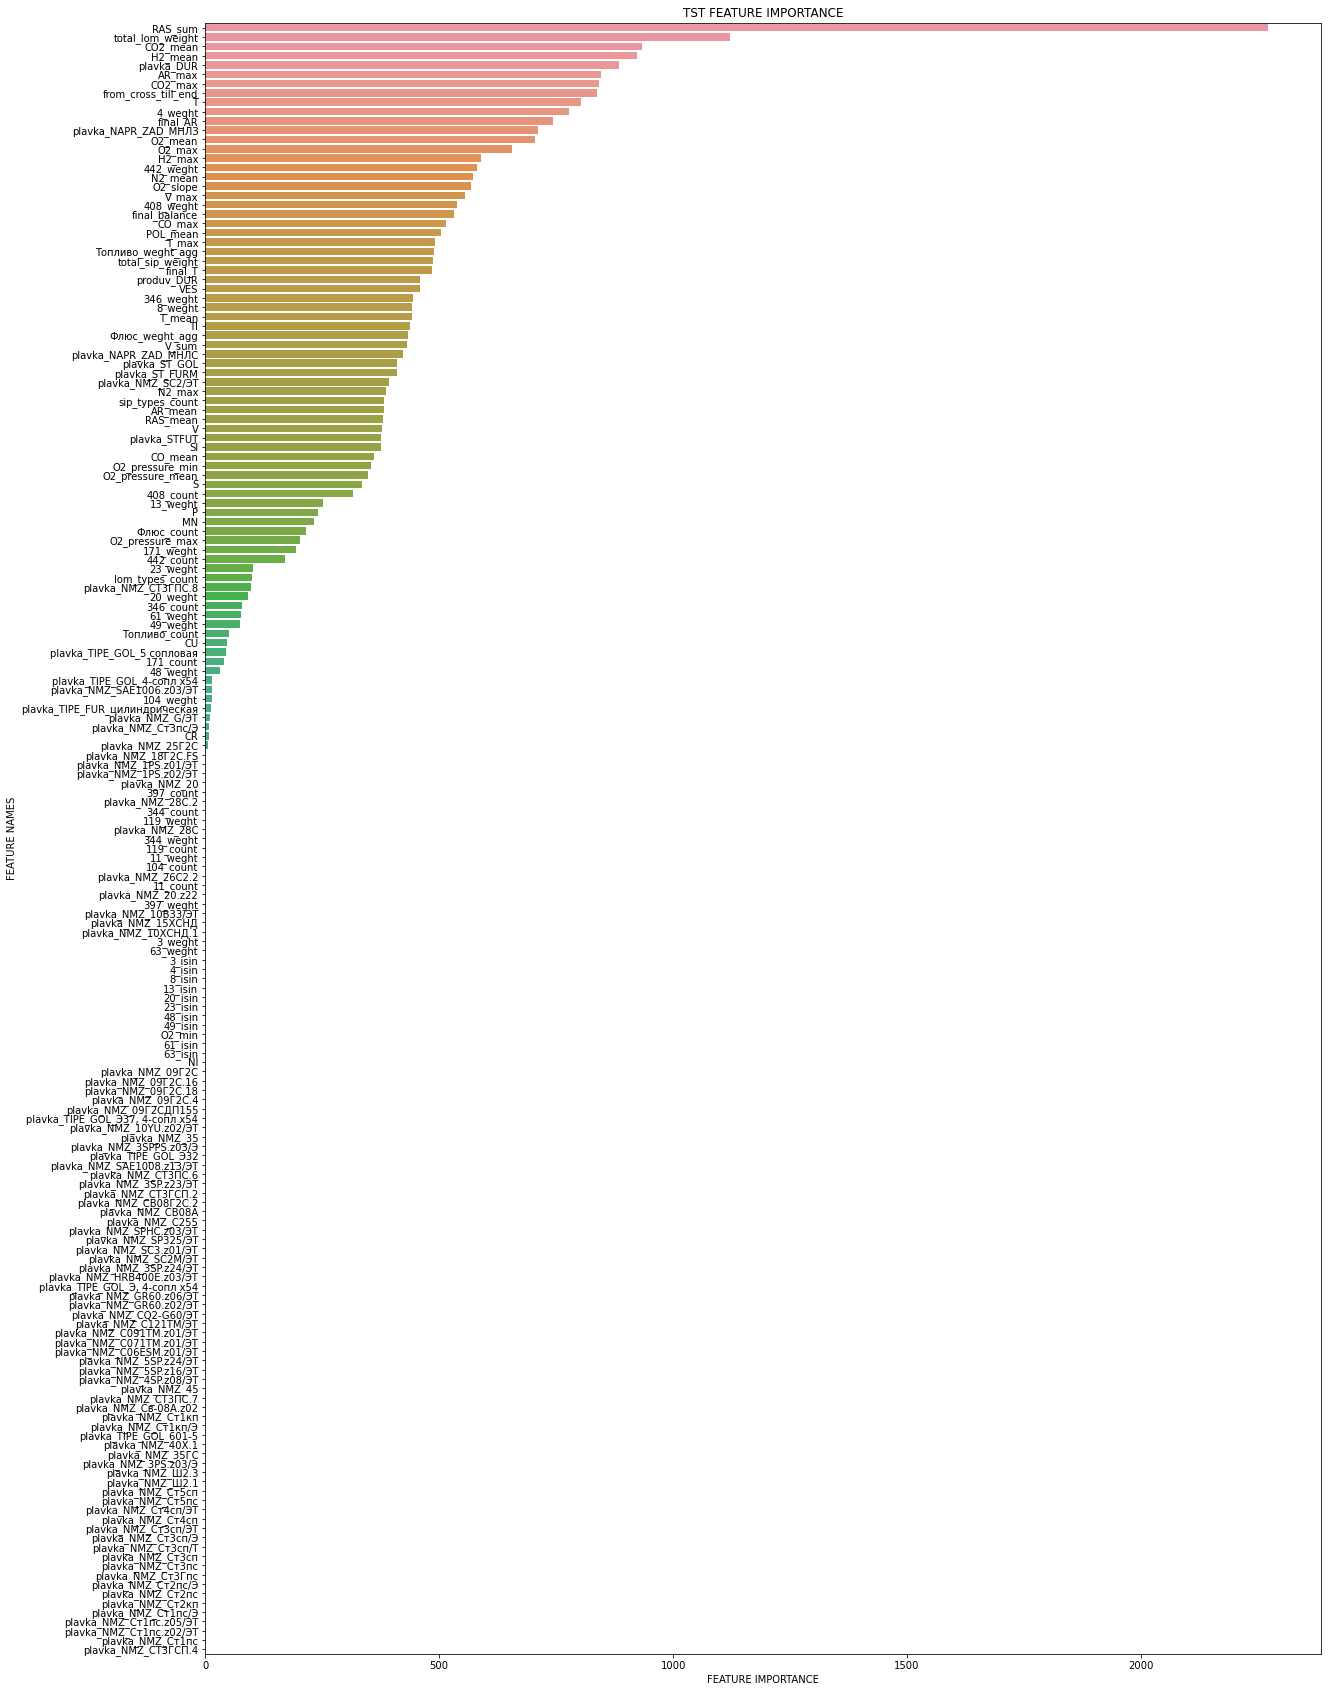

In [92]:
TST =  plot_feature_importance(model_t.feature_importances_, X_train_T.columns, 'TST')

In [94]:
for i, (X_TRAIN, X_TEST) in enumerate([[X_train_C, X_test_C], [X_train_T, X_test_T]]):
    if i == 0:
        features_to_check = C['feature_names'][:20].values
        print('########### C ##########')
    else:
        features_to_check = TST['feature_names'][:20].values
        print('########### TST ###########')
    X, X_ = X_TRAIN[features_to_check], X_TEST[features_to_check]
    for col in X.columns:
        if  stats.ttest_ind(X[col].values, X_[col].values)[1] < 0.05:
            print(col, f'DATA SHIFT!!!!')
        else:
            print(col, 'is ok')

########### C ##########
final_balance DATA SHIFT!!!!
final_T DATA SHIFT!!!!
AR_max DATA SHIFT!!!!
final_AR DATA SHIFT!!!!
O2_mean DATA SHIFT!!!!
RAS_sum DATA SHIFT!!!!
total_lom_weight DATA SHIFT!!!!
442_weght is ok
plavka_DUR DATA SHIFT!!!!
total_sip_weight is ok
RAS_mean DATA SHIFT!!!!
Флюс_weght_agg DATA SHIFT!!!!
from_cross_till_end DATA SHIFT!!!!
4_weght DATA SHIFT!!!!
N2_max DATA SHIFT!!!!
CO2_max DATA SHIFT!!!!
408_weght DATA SHIFT!!!!
H2_mean is ok
V_max DATA SHIFT!!!!
POL_mean DATA SHIFT!!!!
########### TST ###########
RAS_sum DATA SHIFT!!!!
total_lom_weight DATA SHIFT!!!!
CO2_mean DATA SHIFT!!!!
H2_mean is ok
plavka_DUR DATA SHIFT!!!!
AR_max DATA SHIFT!!!!
CO2_max DATA SHIFT!!!!
from_cross_till_end DATA SHIFT!!!!
T is ok
4_weght DATA SHIFT!!!!
final_AR DATA SHIFT!!!!
plavka_NAPR_ZAD_МНЛЗ DATA SHIFT!!!!
O2_mean DATA SHIFT!!!!
O2_max DATA SHIFT!!!!
H2_max DATA SHIFT!!!!
442_weght is ok
N2_mean DATA SHIFT!!!!
O2_slope DATA SHIFT!!!!
V_max DATA SHIFT!!!!
408_weght is ok


# Check Misstakes

In [95]:
preds_c = model_c.predict(X_train_C)
preds_t = model_t.predict(X_train_T)

In [96]:
y_train_C['preds_C'] = preds_c
y_train_T['preds_T'] = preds_t

## C

In [97]:
y_train_C['abs_error'] = abs(np.exp(y_train_C['C']) - np.exp(y_train_C['preds_C']))
y_train_C['fatal_error'] = abs(y_train_C['abs_error'] >= 0.02)

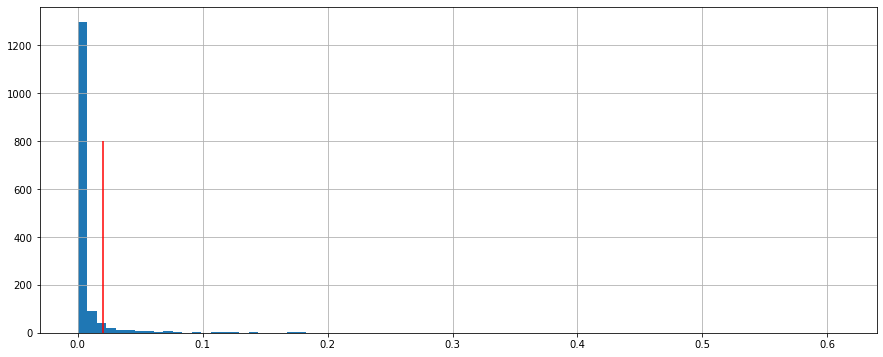

In [98]:
fig = plt.figure(figsize=(15,6))
y_train_C['abs_error'].hist(bins=80);
plt.vlines(0.02, 0, 800, color='red');

In [99]:
df_c = pd.concat([X_train_C, y_train_C], axis=1)

In [100]:
l_tr, _ = make_lom_features(lom_train, lom_test)

In [101]:
s_t, _ = make_sip_features(sip_train, sip_test)

In [102]:
inner_cols_sip = list(set(df_c.columns).intersection(set(s_t.columns)))

In [103]:
inner_cols_lom = list(set(df_c.columns).intersection(set(l_tr.columns)))

In [104]:
512260, 512009

(512260, 512009)

In [105]:
cols_save = df_c.columns
df_c = df_c.merge(s_t[inner_cols_sip + ['NPLV']], on=inner_cols_sip, how='left')[cols_save.to_list() + ['NPLV']]

In [106]:
df_c_fatal = df_c[df_c['fatal_error']==1]

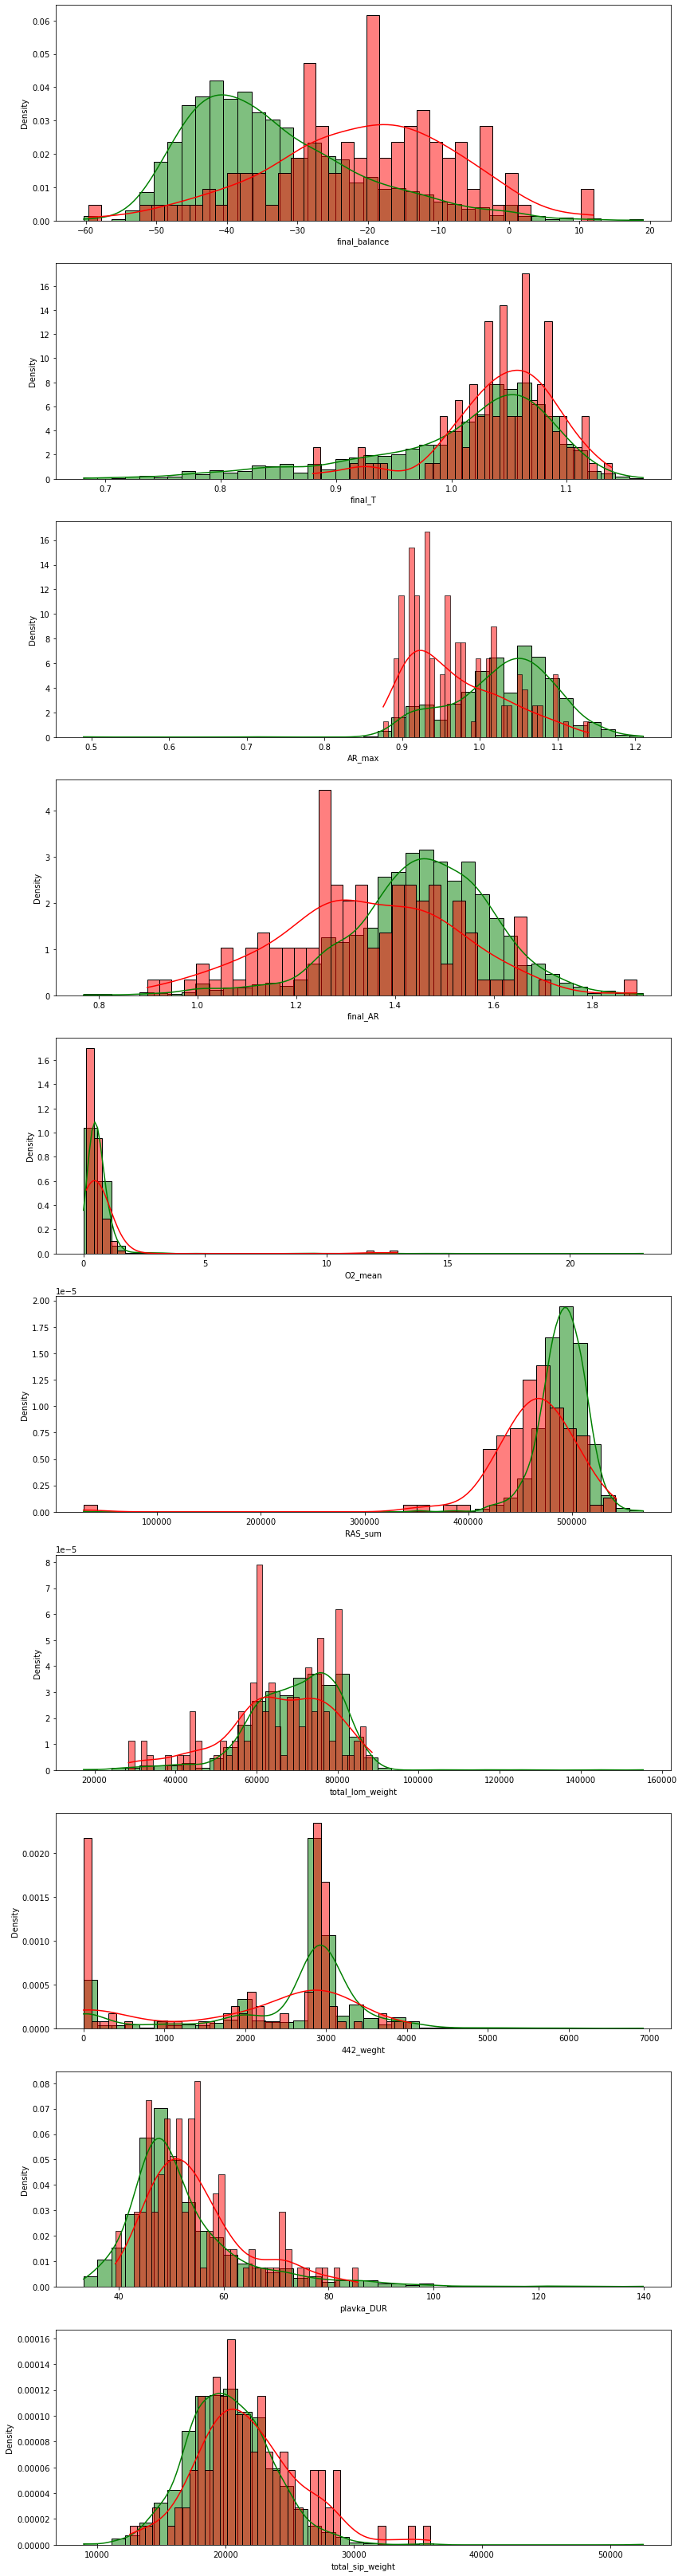

In [107]:
fig, axs = plt.subplots(10, 1, figsize=(12,45))
for i, feature in enumerate(C['feature_names'][:10]):
    sns.histplot(X_train_C[feature], ax=axs[i], kde=True, stat='density', color='green', alpha=0.5, label='train', legend=True, bins=40)
    sns.histplot(df_c_fatal[feature], ax=axs[i], kde=True, stat='density', color='red', alpha=0.5, label='fatal', legend=True, bins=40)
    plt.tight_layout()

## TST

In [108]:
y_train_T['abs_error'] = abs(y_train_T['TST'] - y_train_T['preds_T'])
y_train_T['fatal_error'] = abs(y_train_T['abs_error'] >= 20)

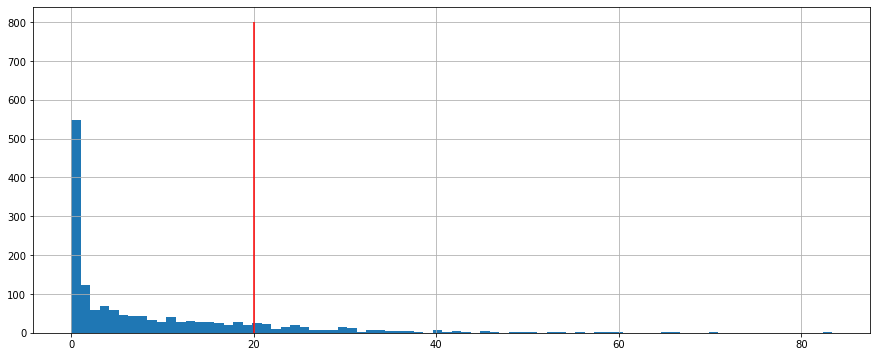

In [109]:
fig = plt.figure(figsize=(15,6))
y_train_T['abs_error'].hist(bins=80);
plt.vlines(20, 0, 800, color='red');

In [110]:
df_t = pd.concat([X_train_T, y_train_T], axis=1)

In [111]:
s_t, _ = make_sip_features(sip_train, sip_test)

In [112]:
inner_cols_sip = list(set(df_t.columns).intersection(set(s_t.columns)))

In [113]:
cols_save = df_t.columns
df_t = df_t.merge(s_t[inner_cols_sip + ['NPLV']], on=inner_cols_sip, how='left')[cols_save.to_list() + ['NPLV']]

In [114]:
df_t_fatal = df_t[df_t['fatal_error']==1]

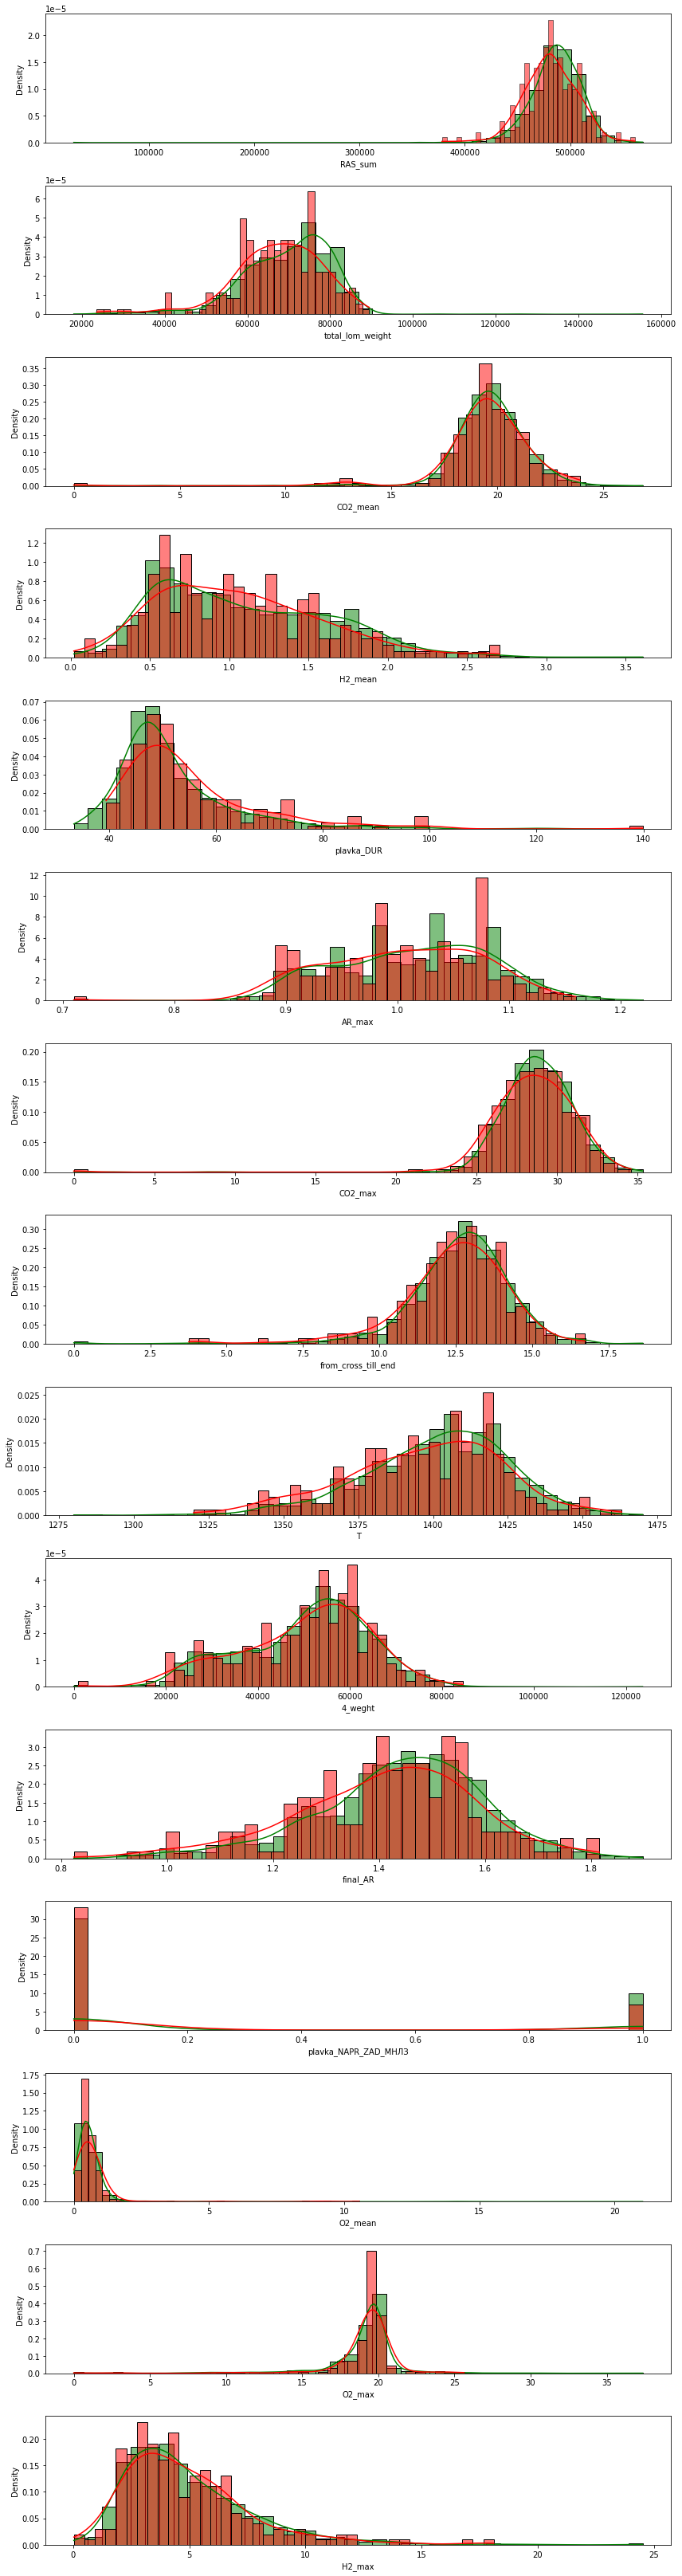

In [115]:
fig, axs = plt.subplots(15, 1, figsize=(12,45))
for i, feature in enumerate(TST['feature_names'][:15]):
    sns.histplot(X_train_T[feature], ax=axs[i], kde=True, stat='density', color='green', alpha=0.5, label='train', legend=True, bins=40)
    sns.histplot(df_t_fatal[feature], ax=axs[i], kde=True, stat='density', color='red', alpha=0.5, label='fatal', legend=True, bins=40)
    plt.tight_layout()

In [402]:
train, _ , _= assemble_features(drop_time_features=False, pred_type='C')

<ipython-input-38-83c14ccbc800>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chronom_test['produv_DUR'] = (chronom_test['VR_KON'] - chronom_test['VR_NACH']) / np.timedelta64(1, 'm')


In [405]:
train[['DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON', 'VR_NACH', 'VR_KON']]

,DATA_ZAMERA,plavka_VR_NACH,plavka_VR_KON,VR_NACH,VR_KON
0,2021-01-01 03:15:03,2021-01-01 03:08:11,2021-01-01 03:51:10,2021-01-01 03:18:25,2021-01-01 03:37:55
1,2021-01-01 04:23:48,2021-01-01 04:00:44,2021-01-01 05:07:28,2021-01-01 04:26:54,2021-01-01 04:47:24
2,2021-01-01 05:21:40,2021-01-01 05:12:29,2021-01-01 06:00:53,2021-01-01 05:25:08,2021-01-01 05:45:34
3,2021-01-01 06:20:57,2021-01-01 06:13:48,2021-01-01 07:08:39,2021-01-01 06:23:51,2021-01-01 06:41:29
4,2021-01-01 07:23:02,2021-01-01 07:13:44,2021-01-01 08:01:59,2021-01-01 07:26:05,2021-01-01 07:46:44
...,...,...,...,...,...
1529,2021-04-26 11:29:44,2021-04-26 11:28:16,2021-04-26 12:03:45,2021-04-26 11:33:28,2021-04-26 11:51:22
1530,2021-04-26 12:16:30,2021-04-26 12:20:03,2021-04-26 12:58:09,2021-04-26 12:30:38,2021-04-26 12:48:43
1531,2021-04-26 12:53:40,2021-04-26 13:04:26,2021-04-26 13:55:50,2021-04-26 13:10:10,2021-04-26 13:27:53
1532,2021-04-26 14:33:29,2021-04-26 15:21:37,2021-04-26 16:16:42,2021-04-26 15:35:46,2021-04-26 15:53:24


In [408]:
train['dayofyear'] = train['VR_NACH'].dt.dayofyear

In [411]:
train['cos_dayofyear'] = np.cos(2 * np.pi * train['dayofyear'] / 365)
train['sin_dayofyear'] = np.sin(2 * np.pi * train['dayofyear'] / 365)

In [412]:
train

,lom_types_count,total_lom_weight,3_weght,4_weght,8_weght,13_weght,20_weght,23_weght,48_weght,49_weght,...,Флюс_count,VR_NACH,VR_KON,produv_DUR,RAS_sum,RAS_mean,POL_mean,dayofyear,cos_dayofyear,sin_dayofyear
0,3,76200,0.0,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,...,7.0,2021-01-01 03:18:25,2021-01-01 03:37:55,19.500000,487319.224185,833.024315,1.145962,1,0.999852,0.017213
1,3,78600,0.0,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,...,9.0,2021-01-01 04:26:54,2021-01-01 04:47:24,20.500000,511026.275132,830.937033,1.352291,1,0.999852,0.017213
2,4,76300,0.0,45900.0,22400.0,2000.0,0.0,6000.0,0.0,0.0,...,7.0,2021-01-01 05:25:08,2021-01-01 05:45:34,20.433333,502845.270435,820.302236,1.266852,1,0.999852,0.017213
3,3,84100,0.0,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,...,7.0,2021-01-01 06:23:51,2021-01-01 06:41:29,17.633333,426144.000000,805.565217,1.442741,1,0.999852,0.017213
4,3,76100,0.0,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,...,11.0,2021-01-01 07:26:05,2021-01-01 07:46:44,20.650000,503721.000000,812.453226,1.147468,1,0.999852,0.017213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,3,75800,0.0,56800.0,0.0,3000.0,0.0,0.0,16000.0,0.0,...,10.0,2021-04-26 11:33:28,2021-04-26 11:51:22,17.900000,482218.000000,897.985102,1.331713,116,-0.413279,0.910605
1530,3,80600,0.0,73500.0,4100.0,3000.0,0.0,0.0,0.0,0.0,...,10.0,2021-04-26 12:30:38,2021-04-26 12:48:43,18.083333,483006.000000,891.154982,1.451384,116,-0.413279,0.910605
1531,5,73600,0.0,51700.0,3300.0,3000.0,0.0,11500.0,4100.0,0.0,...,15.0,2021-04-26 13:10:10,2021-04-26 13:27:53,17.716667,453256.000000,853.589454,1.487194,116,-0.413279,0.910605
1532,3,64200,0.0,41400.0,0.0,5000.0,0.0,0.0,17800.0,0.0,...,14.0,2021-04-26 15:35:46,2021-04-26 15:53:24,17.633333,441713.000000,834.996219,1.451985,116,-0.413279,0.910605
